# URIBE Y SANTOS EN TWITTER: ESTUDIO DE MINERÍA DE OPINIÓN

## Hernán Cusi, Jessenia Gonzalez e Iván Peñaranda

In [1]:
import tweepy           
import pandas as pd     
import numpy as np 
import csv
import json
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Creación de una App de Twitter

In [2]:
# Tomado de https://dev.to/rodolfoferro/sentiment-analysis-on-trumpss-tweets-using-python-
# We import our access keys:
from credenciales import *    # This will allow us to use the keys as variables

# API's setup:
def twitter_setup():
    """
    Utility function to setup the Twitter's API
    with our access keys provided.
    """
    # Authentication and access using keys:
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

    # Return API with authentication:
    api = tweepy.API(auth)
    return api

In [3]:
api = twitter_setup()

### Extracción de Tweets

In [31]:
# Adatptado de https://www.promptcloud.com/blog/scrape-twitter-data-using-python-r
def get_all_tweets(screen_name):

    # Twitter allows access to only 3240 tweets via this method

    # Authorization and initialization

    #auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    #auth.set_access_token(access_key, access_secret)
    #api = tweepy.API(auth)

    # initialization of a list to hold all Tweets

    all_the_tweets = []

    # We will get the tweets with multiple requests of 200 tweets each

    new_tweets = api.user_timeline(screen_name=screen_name, count=200)

    # saving the most recent tweets

    all_the_tweets.extend(new_tweets)

    # save id of 1 less than the oldest tweet

    oldest_tweet = all_the_tweets[-1].id - 1

    # grabbing tweets till none are left

    while len(new_tweets) > 0:
        # The max_id param will be used subsequently to prevent duplicates
        new_tweets = api.user_timeline(screen_name=screen_name,
                count=200, max_id=oldest_tweet)

        # save most recent tweets

        all_the_tweets.extend(new_tweets)

        # id is updated to oldest tweet - 1 to keep track

        oldest_tweet = all_the_tweets[-1].id - 1
        print ('...%s tweets han sido descargados' % len(all_the_tweets))

    # transforming the tweets into a 2D array that will be used to populate the csv

    outtweets = [[tweet.id_str, tweet.created_at, tweet.source, tweet.favorite_count, tweet.retweet_count,
                 tweet.text, tweet.lang] for tweet in all_the_tweets]

    # writing to the csv file

    with open(screen_name + '_tweets.csv', 'w', encoding='utf8') as f:
        writer = csv.writer(f)
        writer.writerow(['ID', 'Date', 'Source', 'Likes', 'RTs', 'Text', 'Lang'])
        writer.writerows(outtweets)


if __name__ == '__main__':

    # Enter the twitter handle of the person concerned

    get_all_tweets(input("Ingrese el nombre de la cuenta de twitter de la persona cuyos tweets desea descargar:- "))

Ingrese el nombre de la cuenta de twitter de la persona cuyos tweets desea descargar:- JuanManSantos
...400 tweets han sido descargados
...600 tweets han sido descargados
...800 tweets han sido descargados
...1000 tweets han sido descargados
...1200 tweets han sido descargados
...1400 tweets han sido descargados
...1600 tweets han sido descargados
...1800 tweets han sido descargados
...2000 tweets han sido descargados
...2200 tweets han sido descargados
...2400 tweets han sido descargados
...2600 tweets han sido descargados
...2800 tweets han sido descargados
...3000 tweets han sido descargados
...3200 tweets han sido descargados
...3211 tweets han sido descargados
...3211 tweets han sido descargados


### Análisis Exploratorio de los Tweets de Uribe y Santos

In [2]:
dataUribe = pd.read_csv('AlvaroUribeVel_tweets.csv')
dataUribe.head()

,ID,Date,Source,Likes,RTs,Text,Lang
0,1068264150390972421,2018-11-29 22:03:15,Twitter for iPhone,0,17,RT @JenniferAriasF: El empoderamiento de las m...,es
1,1068254080055894019,2018-11-29 21:23:14,Twitter for iPhone,0,20,RT @gabrieljvelasco: #FelizJueves | Buena inic...,es
2,1068199640833695744,2018-11-29 17:46:55,Twitter for iPhone,1721,752,Por segunda vez recuerdo que los congresistas ...,es
3,1068188384064126976,2018-11-29 17:02:11,Twitter for iPhone,0,17,RT @polojuancho16: Felicitaciones a la Conceja...,es
4,1068152587793440769,2018-11-29 14:39:56,Twitter for iPhone,0,114,RT @FelipeSogamoso: Fueron cientos los caídos ...,es


In [3]:
dataSantos = pd.read_csv('JuanManSantos_tweets.csv')
dataSantos.head()

,ID,Date,Source,Likes,RTs,Text,Lang
0,1071094752748158976,2018-12-07 17:31:03,Twitter for iPhone,594,104,Agradezco la gran ayuda de @UN y el permanente...,es
1,1068880068586409985,2018-12-01 14:50:41,Twitter for iPhone,1736,167,Recordamos a Bush padre como buen amigo de Col...,es
2,1067191711414272002,2018-11-26 23:01:46,Twitter for iPhone,0,752,"RT @Harvard: Juan Manuel Santos, who won the N...",en
3,1066361066823852032,2018-11-24 16:01:05,Twitter for iPhone,14216,4209,La paz es de todos https://t.co/nD4E5tPvTb,es
4,1065012049141485570,2018-11-20 22:40:34,Twitter for iPhone,0,561,RT @UEenColombia: 'La paz de Colombia es una d...,es


In [4]:
long = []

for tweet in dataUribe['Text']:
    long.append(len(tweet))
    
dataUribe['long'] = long

In [5]:
long = []

for tweet in dataSantos['Text']:
    long.append(len(tweet))
    
dataSantos['long'] = long

In [6]:
dataUribe.head()

,ID,Date,Source,Likes,RTs,Text,Lang,long
0,1068264150390972421,2018-11-29 22:03:15,Twitter for iPhone,0,17,RT @JenniferAriasF: El empoderamiento de las m...,es,140
1,1068254080055894019,2018-11-29 21:23:14,Twitter for iPhone,0,20,RT @gabrieljvelasco: #FelizJueves | Buena inic...,es,140
2,1068199640833695744,2018-11-29 17:46:55,Twitter for iPhone,1721,752,Por segunda vez recuerdo que los congresistas ...,es,114
3,1068188384064126976,2018-11-29 17:02:11,Twitter for iPhone,0,17,RT @polojuancho16: Felicitaciones a la Conceja...,es,140
4,1068152587793440769,2018-11-29 14:39:56,Twitter for iPhone,0,114,RT @FelipeSogamoso: Fueron cientos los caídos ...,es,140


In [7]:
dataSantos.head()

,ID,Date,Source,Likes,RTs,Text,Lang,long
0,1071094752748158976,2018-12-07 17:31:03,Twitter for iPhone,594,104,Agradezco la gran ayuda de @UN y el permanente...,es,140
1,1068880068586409985,2018-12-01 14:50:41,Twitter for iPhone,1736,167,Recordamos a Bush padre como buen amigo de Col...,es,140
2,1067191711414272002,2018-11-26 23:01:46,Twitter for iPhone,0,752,"RT @Harvard: Juan Manuel Santos, who won the N...",en,140
3,1066361066823852032,2018-11-24 16:01:05,Twitter for iPhone,14216,4209,La paz es de todos https://t.co/nD4E5tPvTb,es,42
4,1065012049141485570,2018-11-20 22:40:34,Twitter for iPhone,0,561,RT @UEenColombia: 'La paz de Colombia es una d...,es,140


In [8]:
dataUribe.tail()

,ID,Date,Source,Likes,RTs,Text,Lang,long
3220,1014221041655218176,2018-07-03 18:55:14,Twitter for iPhone,361,464,"Masacre en Argelia, Cauca, deja siete muertos ...",es,93
3221,1014205862607454208,2018-07-03 17:54:55,Twitter for iPhone,5379,1366,Gracias siempre Selección Colombia,es,34
3222,1014203580230852610,2018-07-03 17:45:51,Twitter for iPhone,805,422,"'Justicia justa para policías y soldados', pid...",es,101
3223,1014138296170176512,2018-07-03 13:26:26,Twitter for iPhone,0,311,RT @IrreverentesCol: 🔵 Entrevista. Jaime Amin:...,es,140
3224,1014138281443909634,2018-07-03 13:26:22,Twitter for iPhone,0,3795,"RT @RafaNietoLoaiza: ""Todo el evangelio de Kar...",es,134


In [9]:
dataSantos.tail()

,ID,Date,Source,Likes,RTs,Text,Lang,long
3206,872878432174080000,2017-06-08 18:10:10,Twitter Web Client,67,18,Avance de obra Girardot-Honda-Puerto Salgar es...,es,140
3207,872876545341304832,2017-06-08 18:02:40,Twitter Web Client,76,23,Esta #RevoluciónDeLaInfraestructura lleva 24 o...,es,140
3208,872875808116944896,2017-06-08 17:59:44,Twitter Web Client,117,47,Cuando vía Girardot-Honda-Puerto Salgar esté f...,es,140
3209,872873800538492928,2017-06-08 17:51:45,Twitter Web Client,145,35,Colombia está viendo y sintiendo la #Revolució...,es,139
3210,872825925540470785,2017-06-08 14:41:31,Twitter Web Client,104,39,Revisaremos avance de obra 4G Girardot-Honda-P...,es,139


In [10]:
# Estadísticos de las variables numéricas
with pd.option_context('float_format', '{:.2f}'.format): print(dataUribe.describe())

                          ID    Likes      RTs    long
count                3225.00  3225.00  3225.00 3225.00
mean  1042450457737782656.00   596.43   715.96  116.96
std     16123286300298268.00  1337.81  1139.28   34.20
min   1014138281443909632.00     0.00     9.00   23.00
25%   1027394296377425920.00     0.00   131.00   98.00
50%   1043483818970238976.00   101.00   343.00  139.00
75%   1055886761375752192.00   555.00   828.00  140.00
max   1068264150390972416.00 16530.00 24134.00  150.00


In [11]:
# Estadísticos de las variables numéricas
with pd.option_context('float_format', '{:.2f}'.format): print(dataSantos.describe())

                          ID    Likes      RTs    long
count                3211.00  3211.00  3211.00 3211.00
mean   942107599459240576.00   667.78   228.35  137.40
std     49480480372544816.00  2544.90  1023.67    9.38
min    872825925540470784.00     0.00     0.00   20.00
25%    899125704643803136.00    98.00    36.00  139.00
50%    928315813580427264.00   183.00    62.00  140.00
75%    989280046425780224.00   401.00   132.50  140.00
max   1071094752748158976.00 68544.00 33967.00  149.00


#### Tweets con mayor número de likes y re-tweets de Uribe

In [12]:
# Tomado de https://dev.to/rodolfoferro/sentiment-analysis-on-trumpss-tweets-using-python-
# We extract the tweet with more FAVs and more RTs:

fav_max = np.max(dataUribe['Likes'])
rt_max  = np.max(dataUribe['RTs'])

fav = dataUribe[dataUribe.Likes == fav_max].index[0]
rt  = dataUribe[dataUribe.RTs == rt_max].index[0]

# Max FAVs:
print("El tweet con más likes de Uribe es: \n{}".format(dataUribe['Text'][fav]))
print("Número de likes: {}".format(fav_max))
print("{} characters.\n".format(dataUribe['long'][fav]))

# Max RTs:
print("El tweet con más retweets de Uribe es: \n{}".format(dataUribe['Text'][rt]))
print("Número de retweets: {}".format(rt_max))
print("{} characters.\n".format(dataUribe['long'][rt]))

El tweet con más likes de Uribe es: 
Que Dios ayude a Colombia y al Presidente Iván Duque https://t.co/3dg9hjnGX7
Número de likes: 16530
76 characters.

El tweet con más retweets de Uribe es: 
RT @realDonaldTrump: All of America is in mourning over the mass murder of Jewish Americans at the Tree of Life Synagogue in Pittsburgh. We…
Número de retweets: 24134
140 characters.



#### Tweets con mayor número de likes y re-tweets de Santos

In [13]:
# Tomado de https://dev.to/rodolfoferro/sentiment-analysis-on-trumpss-tweets-using-python-
# We extract the tweet with more FAVs and more RTs:

fav_max = np.max(dataSantos['Likes'])
rt_max  = np.max(dataSantos['RTs'])

fav = dataSantos[dataSantos.Likes == fav_max].index[0]
rt  = dataSantos[dataSantos.RTs == rt_max].index[0]

# Max FAVs:
print("El tweet con más likes de Santos es: \n{}".format(dataSantos['Text'][fav]))
print("Número de likes: {}".format(fav_max))
print("{} characters.\n".format(dataSantos['long'][fav]))

# Max RTs:
print("El tweet con más retweets de Santos es: \n{}".format(dataSantos['Text'][rt]))
print("Número de retweets: {}".format(rt_max))
print("{} characters.\n".format(dataSantos['long'][rt]))

El tweet con más likes de Santos es: 
Y si me preguntan si lo arriesgaría todo otra vez por la paz de este país, diría mil veces: ¡SÍ! Ha sido un honor.… https://t.co/5edjcWgsVa
Número de likes: 68544
139 characters.

El tweet con más retweets de Santos es: 
RT @Pontifex_es: Queridos amigos, por favor rueguen por mí y por toda Colombia donde iré de viaje en búsqueda de la reconciliación y la paz…
Número de retweets: 33967
140 characters.



#### Variación con respecto al tiempo de la actividad de Uribe y Santos en Twitter

In [38]:
# Tomado de https://dev.to/rodolfoferro/sentiment-analysis-on-trumpss-tweets-using-python-
# We create time series for data:

tlen = pd.Series(data=dataUribe['long'].values, index=dataUribe['Date'])
tfav = pd.Series(data=dataUribe['Likes'].values, index=dataUribe['Date'])
tret = pd.Series(data=dataUribe['RTs'].values, index=dataUribe['Date'])

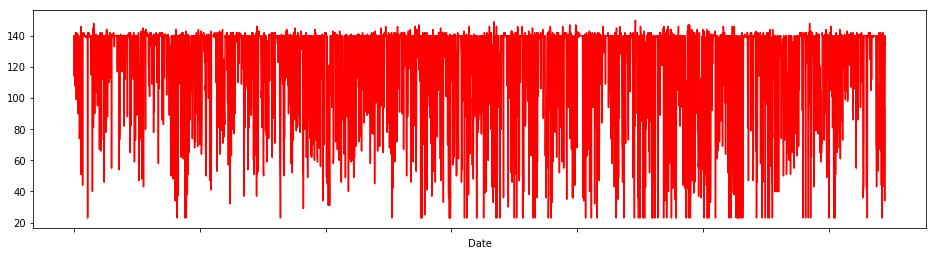

In [39]:
# Lenghts along time:
tlen.plot(figsize=(16,4), color='r');

In [53]:
# Tomado de https://dev.to/rodolfoferro/sentiment-analysis-on-trumpss-tweets-using-python-
# We create time series for data:

tlen = pd.Series(data=dataSantos['long'].values, index=dataSantos['Date'])
tfav = pd.Series(data=dataSantos['Likes'].values, index=dataSantos['Date'])
tret = pd.Series(data=dataSantos['RTs'].values, index=dataSantos['Date'])

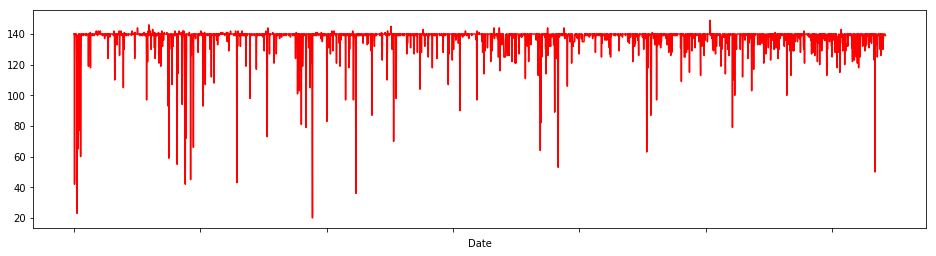

In [54]:
# Lenghts along time:
tlen.plot(figsize=(16,4), color='r');

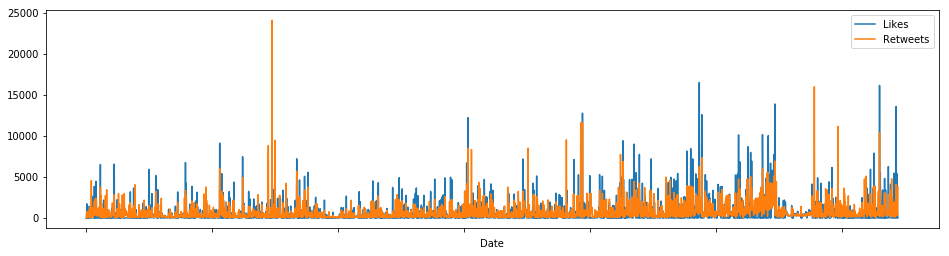

In [13]:
# Tomado de https://dev.to/rodolfoferro/sentiment-analysis-on-trumpss-tweets-using-python-
# Likes vs retweets visualization:
tfav.plot(figsize=(16,4), label="Likes", legend=True)
tret.plot(figsize=(16,4), label="Retweets", legend=True);

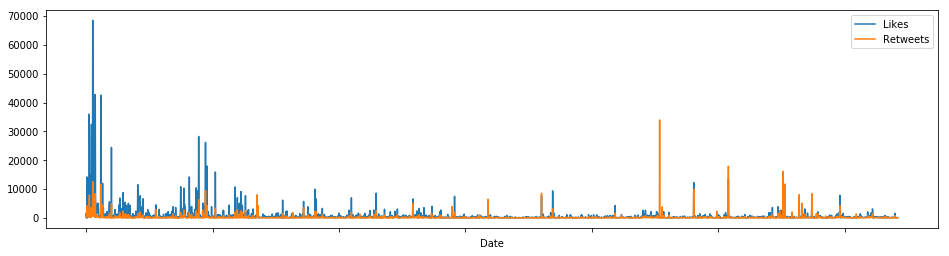

In [55]:
# Tomado de https://dev.to/rodolfoferro/sentiment-analysis-on-trumpss-tweets-using-python-
# Likes vs retweets visualization:
tfav.plot(figsize=(16,4), label="Likes", legend=True)
tret.plot(figsize=(16,4), label="Retweets", legend=True);

#### Fuentes de los tweets de Uribe y Santos

In [40]:
# Tomado de https://dev.to/rodolfoferro/sentiment-analysis-on-trumpss-tweets-using-python-
# We obtain all possible sources:
sources = []
for source in dataUribe['Source']:
    if source not in sources:
        sources.append(source)

# We print sources list:
print("Creation of content sources:")
for source in sources:
    print("* {}".format(source))

Creation of content sources:
* Twitter for iPhone
* Twitter for iPad
* Twitter Media Studio
* Twishort
* Twitter Web Client
* Twitter for Android
* Twitter Lite
* Periscope
* Twishort Client


In [56]:
# We obtain all possible sources:
sources = []
for source in dataSantos['Source']:
    if source not in sources:
        sources.append(source)

# We print sources list:
print("Creation of content sources:")
for source in sources:
    print("* {}".format(source))

Creation of content sources:
* Twitter for iPhone
* Twitter for Android
* Twitter Web Client
* Twitter Media Studio
* Twitter Lite
* Twitter for iPad
* Periscope


Text(0.5,0,'Tipo de fuente')

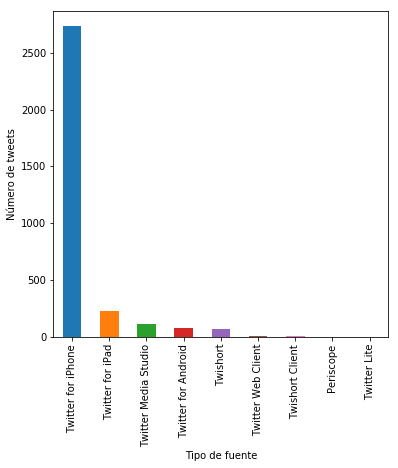

In [21]:
plt.figure(figsize=(10,10))
dataUribe['Source'].value_counts().plot(kind="bar", figsize=(6,6), stacked=False)
plt.ylabel('Número de tweets')
plt.xlabel('Tipo de fuente')

Text(0.5,0,'Tipo de fuente')

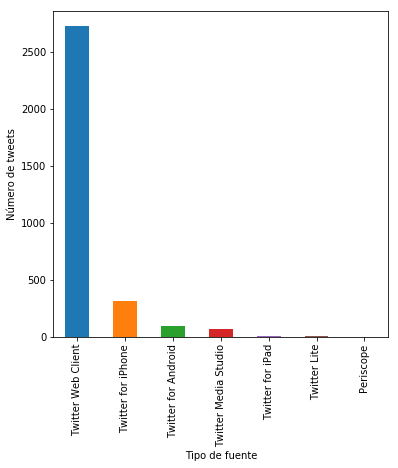

In [57]:
plt.figure(figsize=(10,10))
dataSantos['Source'].value_counts().plot(kind="bar", figsize=(6,6), stacked=False)
plt.ylabel('Número de tweets')
plt.xlabel('Tipo de fuente')

#### Idiomas de los tweets de Uribe y Santos

In [42]:
dataUribe['Lang'].value_counts()

es     3056
und     121
en       19
ca       13
pt        7
in        3
fr        2
ht        2
it        1
pl        1
Name: Lang, dtype: int64

In [58]:
dataSantos['Lang'].value_counts()

es     3181
en       20
fr        4
und       3
ca        3
Name: Lang, dtype: int64

Text(0.5,0,'Idioma')

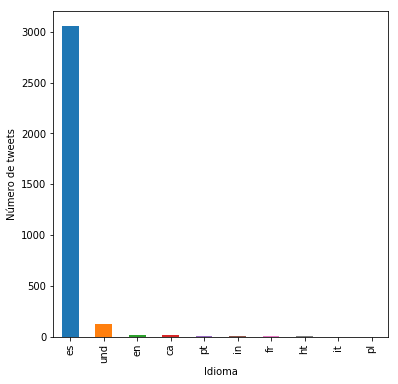

In [43]:
plt.figure(figsize=(10,10))
dataUribe['Lang'].value_counts().plot(kind="bar", figsize=(6,6), stacked=False)
plt.ylabel('Número de tweets')
plt.xlabel('Idioma')

Text(0.5,0,'Idioma')

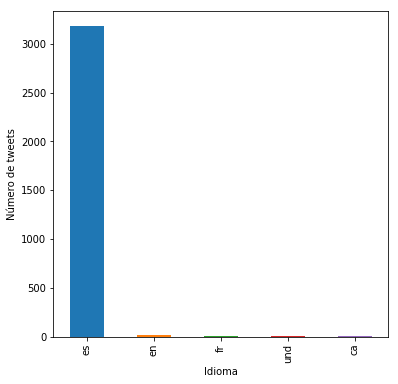

In [59]:
plt.figure(figsize=(10,10))
dataSantos['Lang'].value_counts().plot(kind="bar", figsize=(6,6), stacked=False)
plt.ylabel('Número de tweets')
plt.xlabel('Idioma')

In [14]:
# Creación de un nuevo dataset que incluye solamente los tweets publicados en español
dataUribeSP = dataUribe
dataUribeSP = dataUribe[dataUribe.Lang == 'es']

In [15]:
# Creación de un nuevo dataset que incluye solamente los tweets publicados en español
dataSantosSP = dataSantos
dataSantosSP = dataSantos[dataSantos.Lang == 'es']

#### Visualización de los tweets de Uribe y Santos en nube de palabras

In [24]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [16]:
from nltk.corpus import stopwords
stop = stopwords.words('spanish')

In [17]:
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                                and word != 'vía'
                            ])
    wordcloud = WordCloud(stopwords=stop,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

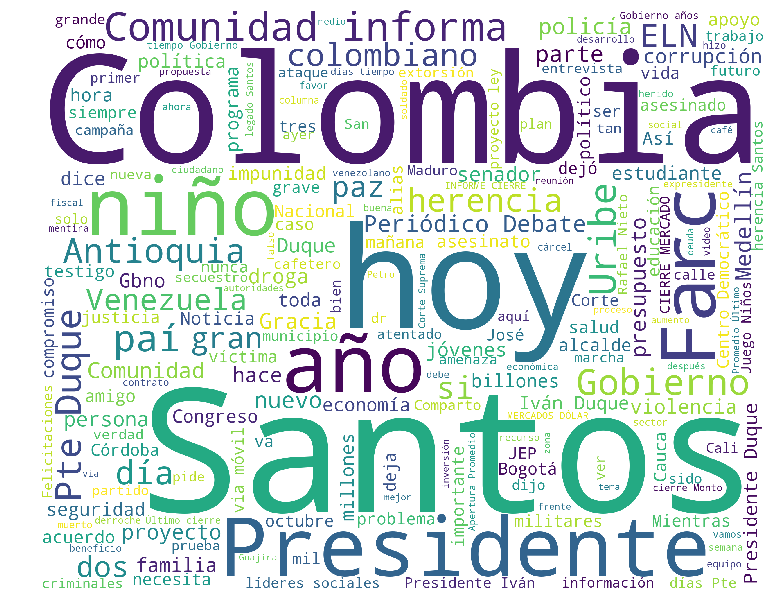

In [27]:
wordcloud_draw(dataUribeSP['Text'],'white')

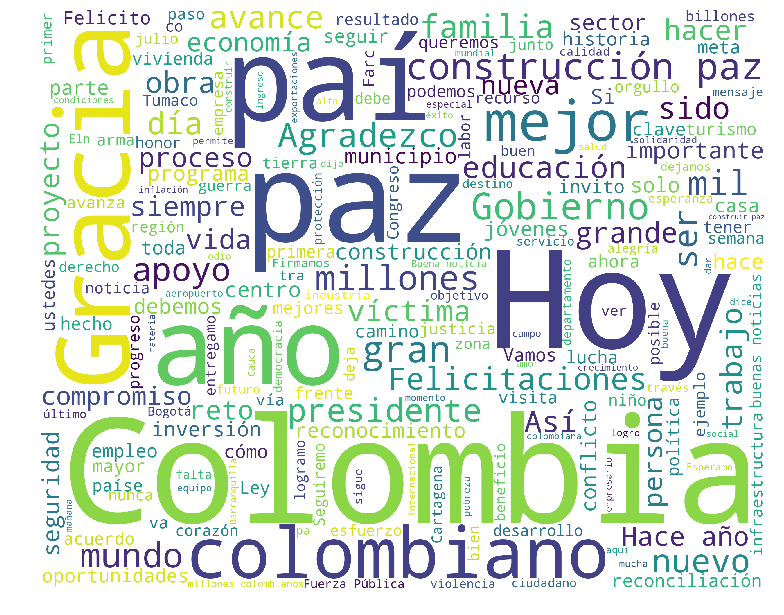

In [28]:
wordcloud_draw(dataSantosSP['Text'],'white')

### Creación y Procesamiento de los conjuntos de datos que serán utilizados por los Clasificadores

#### Creación de subconjuntos de tweets de Uribe y Santos para etiquetado manual

In [18]:
print(dataUribeSP.shape)
print(dataSantosSP.shape)

(3056, 8)
(3181, 8)


In [19]:
from sklearn.model_selection import train_test_split

dataU_train, dataU_test = train_test_split(dataUribeSP,  test_size=0.170, random_state=0)
dataS_train, dataS_test = train_test_split(dataSantosSP, test_size=0.164, random_state=0)

In [20]:
print(dataU_test.shape)
print(dataS_test.shape)

(520, 8)
(522, 8)


In [ ]:
writer = pd.ExcelWriter('Uribe&Santos_trinos.xlsx')
dataU_test.to_excel(writer,'Uribe')
dataS_test.to_excel(writer,'Santos')
writer.save()

#### Creación de un dataset a partir de los datos de TASS

In [21]:
import xml.etree.ElementTree as ET
tree = ET.parse('TASS_data/general_corpus_2012/general-train-tagged-3l.xml')
root = tree.getroot()

In [22]:
train_set = pd.DataFrame({'tweet_id':[],'tweetText':[],'polarity_value':[],'polarity_type':[],'topic':[]})
row=0
for tweet in root:
    tweet_id = 'ID:'+tweet.find('tweetid').text
    #user = tweet.find('user').text
    tweetText = tweet.find('content').text
    lang = tweet.find('lang').text
    polarity_value = tweet.find('sentiments').find('polarity').find('value').text
    polarity_type = tweet.find('sentiments').find('polarity').find('type').text
    topic = tweet.find('topics').find('topic').text
    
    if lang == 'es':
        train_set.loc[row] = [tweet_id,tweetText,polarity_value,polarity_type,topic]
        row+=1

In [23]:
train_set.columns = ['tweet_id', 'tweetText', 'polarity_value', 'polarity_type', 'topic']

In [24]:
train_set.head()

,tweet_id,tweetText,polarity_value,polarity_type,topic
0,ID:142389495503925248,"Salgo de #VeoTV , que día más largoooooo...",NONE,AGREEMENT,otros
1,ID:142389933619945473,@PauladeLasHeras No te libraras de ayudar me/n...,NEU,DISAGREEMENT,otros
2,ID:142391947707940864,@marodriguezb Gracias MAR,P,AGREEMENT,otros
3,ID:142416095012339712,"Off pensando en el regalito Sinde, la que se v...",N,AGREEMENT,política
4,ID:142422495721562112,Conozco a alguien q es adicto al drama! Ja ja ...,P,AGREEMENT,otros


In [35]:
train_set.topic.value_counts()

política           2715
otros              1620
entretenimiento    1209
economía            525
música              412
fútbol              225
cine                183
tecnología          144
deportes            101
literatura           84
Name: topic, dtype: int64

In [36]:
train_set.shape

(7218, 5)

In [25]:
train_set.polarity_value.value_counts()

P       2884
N       2182
NONE    1482
NEU      670
Name: polarity_value, dtype: int64

In [39]:
train_none = train_set.loc[(train_set.polarity_value == 'NONE')]
train_none.head(20)

,tweet_id,tweetText,polarity_value,polarity_type,topic
0,ID:142389495503925248,"Salgo de #VeoTV , que día más largoooooo...",NONE,AGREEMENT,otros
5,ID:142424715175280640,"RT @FabHddzC: Si amas a alguien, déjalo libre....",NONE,AGREEMENT,música
7,ID:142493511634259968,Hoy asisitiré en Madrid a un seminario sobre l...,NONE,AGREEMENT,política
15,ID:142512151628750849,Noooooos días! Me he dormidoooooo ya estoy en ...,NONE,AGREEMENT,otros
16,ID:142512293681438720,Vamos a por el viernes (@ Ayuntamiento de Mála...,NONE,AGREEMENT,otros
29,ID:142558452257013760,"""Hasta ahora, los filósofos han tratado de com...",NONE,AGREEMENT,literatura
30,ID:142561346645540864,Open Master Class@javiersolana &Pedro Alonso o...,NONE,AGREEMENT,deportes
39,ID:142589717148479489,En el blog: Defender la solidaridad http://t.c...,NONE,AGREEMENT,otros
42,ID:142594023780134912,Ya he presentado la credencial de diputado en ...,NONE,AGREEMENT,política
44,ID:142603527712280577,El post de hoy en mi blog http://t.co/nzhcgrxn,NONE,AGREEMENT,entretenimiento


Dado que los tweets etiquetados con polaridad igual a NONE realmente son neutros estos se convierten a este último valor de polaridad.

In [5]:
#train_set = train_set.loc[(train_set.polarity_value == 'P') | (train_set.polarity_value == 'N') | (train_set.polarity_value == 'NEU')]

In [26]:
for value in train_set.polarity_value.unique():
    if value == "NONE":
        train_set.loc[train_set['polarity_value'] == value, 'polarity_value'] = "NEU"        

In [27]:
train_set.polarity_value.value_counts()

P      2884
N      2182
NEU    2152
Name: polarity_value, dtype: int64

In [28]:
train_set = train_set.loc[(train_set.topic == 'política') | (train_set.topic == 'economía')]

In [44]:
train_set.shape

(3240, 5)

In [29]:
train_set['processed_Text'] = train_set['tweetText']

In [30]:
train_set.head()

,tweet_id,tweetText,polarity_value,polarity_type,topic,processed_Text
3,ID:142416095012339712,"Off pensando en el regalito Sinde, la que se v...",N,AGREEMENT,política,"Off pensando en el regalito Sinde, la que se v..."
7,ID:142493511634259968,Hoy asisitiré en Madrid a un seminario sobre l...,NEU,AGREEMENT,política,Hoy asisitiré en Madrid a un seminario sobre l...
9,ID:142496796416016384,Desde el escaño. Todo listo para empezar #endi...,P,AGREEMENT,política,Desde el escaño. Todo listo para empezar #endi...
11,ID:142499355360903168,Un sistema económico q recorta dinero para pre...,P,AGREEMENT,economía,Un sistema económico q recorta dinero para pre...
17,ID:142513785154969600,La Universidad confía en De la Calle para enca...,P,AGREEMENT,política,La Universidad confía en De la Calle para enca...


#### Procesamiento de los datos del TASS

Adaptado de https://github.com/NatashaSvic/NLP_Spanish_Sentiment_Anaylsis_Text_Generation/blob/master/NLP_Colombia_Election_Sentiments.ipynb

In [31]:
# Sustitución de hashtags
import re
hash_regex = re.compile(r"#(\w+)")
hstgs = [] # To store the hashtags so we can exclude them from some parts of the analysis
def hash_repl(match):
    _ = '__HASH_'+match.group(1).upper()
    hstgs.append(_)
    return _

In [32]:
# Sustitución de nombres de usuario
user_regex = re.compile(r"@(\w+)")
usr_names = [] # To store the user names so we can exclude them from some parts of the analysis
def user_repl(match):
    _ = '__user_'+match.group(1).upper()
    usr_names.append(_)
    return _

In [33]:
# Eliminación de urls
url_regex = re.compile(r"(http|https|ftp)://[a-zA-Z0-9\./]+")
def url_repl(match):
    return 

In [34]:
# Repeating words like hurrrryyyyyy
rpt_regex = re.compile(r"(.)\1{1,}", re.IGNORECASE);
def rpt_repl(match):
    return match.group(1)+match.group(1)

In [35]:
# Spliting by word boundaries
word_bound_regex = re.compile(r"\W+")

# Punctuations
punctuations = \
	[	#('',		['.', ] )	,\
		#('',		[',', ] )	,\
		#('',		['\'', '\"', ] )	,\
		#('__PUNC_EXCL',		['!', '¡', ] )	,\
		#('__PUNC_QUES',		['?', '¿', ] )	,\
		#('__PUNC_ELLP',		['...', '…', ] )	,\
	]

#For punctuation replacement
def punctuations_repl(match):
	text = match.group(0)
	repl = []
	for (key, parr) in punctuations :
		for punc in parr :
			if punc in text:
				repl.append(key)
	if( len(repl)>0 ) :
		return ' '+' '.join(repl)+' '
	else :
		return ' '

In [36]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')

In [37]:
def sb_stem(text, only_first=0):
    text = [word if(word[0:2]=='__') else word.lower() for word in text.split() if ((len(word) >= 3) or (word in ['no','si', 'sí', 'ni']))] 
    text = [stemmer.stem(w) if w[0:2]!='__' else w for w in text ]
    
    return(text)

In [38]:
def processAll(text):
    text = re.sub( hash_regex, hash_repl, text )
    text = re.sub( user_regex, user_repl, text)
    text = re.sub( url_regex, url_repl, text )
    
    text = text.replace('\'','')
    
    text = re.sub( word_bound_regex , punctuations_repl, text )
    text = re.sub( rpt_regex, rpt_repl, text )
    
    text = sb_stem(text)    
    return text

In [39]:
texto = train_set['tweetText'][18]
print(texto)

¿Me ayudáis a que #indultoneiro sea TT? Por si Zapatero quiere alguna sugerencia para el último consejo de ministros http://t.co/Qao9uvsG


In [40]:
processAll(texto)

['ayud',
 'que',
 '__HASH_INDULTONEIRO',
 'sea',
 'por',
 'si',
 'zapater',
 'quier',
 'algun',
 'sugerent',
 'par',
 'ultim',
 'consej',
 'ministr']

In [41]:
print(" ".join(processAll(texto)))

ayud que __HASH_INDULTONEIRO sea por si zapater quier algun sugerent par ultim consej ministr


In [42]:
train_set['processed_Text'] = train_set.tweetText.apply(processAll)
train_set.head()

,tweet_id,tweetText,polarity_value,polarity_type,topic,processed_Text
3,ID:142416095012339712,"Off pensando en el regalito Sinde, la que se v...",N,AGREEMENT,política,"[off, pens, regalit, sind, que, sga, cuand, va..."
7,ID:142493511634259968,Hoy asisitiré en Madrid a un seminario sobre l...,NEU,AGREEMENT,política,"[hoy, asisit, madr, seminari, sobr, estrategi,..."
9,ID:142496796416016384,Desde el escaño. Todo listo para empezar #endi...,P,AGREEMENT,política,"[desd, escañ, tod, list, par, empez, __HASH_EN..."
11,ID:142499355360903168,Un sistema económico q recorta dinero para pre...,P,AGREEMENT,economía,"[sistem, econom, recort, diner, par, prestacio..."
17,ID:142513785154969600,La Universidad confía en De la Calle para enca...,P,AGREEMENT,política,"[univers, conf, call, par, encar, sus, ret, ma..."


In [43]:
def unir(text):
    text = " ".join(text)
    return text

In [44]:
train_set['cleanText'] = train_set.processed_Text.apply(unir)
train_set.head()

,tweet_id,tweetText,polarity_value,polarity_type,topic,processed_Text,cleanText
3,ID:142416095012339712,"Off pensando en el regalito Sinde, la que se v...",N,AGREEMENT,política,"[off, pens, regalit, sind, que, sga, cuand, va...",off pens regalit sind que sga cuand van sus co...
7,ID:142493511634259968,Hoy asisitiré en Madrid a un seminario sobre l...,NEU,AGREEMENT,política,"[hoy, asisit, madr, seminari, sobr, estrategi,...",hoy asisit madr seminari sobr estrategi españo...
9,ID:142496796416016384,Desde el escaño. Todo listo para empezar #endi...,P,AGREEMENT,política,"[desd, escañ, tod, list, par, empez, __HASH_EN...",desd escañ tod list par empez __HASH_ENDIASCOM...
11,ID:142499355360903168,Un sistema económico q recorta dinero para pre...,P,AGREEMENT,economía,"[sistem, econom, recort, diner, par, prestacio...",sistem econom recort diner par prestacion soci...
17,ID:142513785154969600,La Universidad confía en De la Calle para enca...,P,AGREEMENT,política,"[univers, conf, call, par, encar, sus, ret, ma...",univers conf call par encar sus ret mas ambici


#### N-grams más frecuentes

In [45]:
from nltk import ngrams
def ngrams(input_list):
    #onegrams = input_list
    bigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:]))]
    trigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:], input_list[2:]))]
    return bigrams+trigrams
train_set['grams'] = train_set.processed_Text.apply(ngrams)
train_set[['grams']].head()

,grams
3,"[off pens, pens regalit, regalit sind, sind qu..."
7,"[hoy asisit, asisit madr, madr seminari, semin..."
9,"[desd escañ, escañ tod, tod list, list par, pa..."
11,"[sistem econom, econom recort, recort diner, d..."
17,"[univers conf, conf call, call par, par encar,..."


In [46]:
import collections
def count_words(input):
    cnt = collections.Counter()
    for row in input:
        for word in row:
            cnt[word] += 1
    return cnt

#### Bigramas más frecuentes en los tweets negativos del corpus del TASS

In [47]:
train_set[(train_set.polarity_value == 'N')][['grams']].apply(count_words)['grams'].most_common(20)

[('que no', 50),
 ('dic que', 33),
 ('del pso', 30),
 ('reform laboral', 27),
 ('que los', 25),
 ('los recort', 24),
 ('cre que', 22),
 ('del gobiern', 20),
 ('no tien', 17),
 ('por que', 17),
 ('no hay', 17),
 ('sub impuest', 17),
 ('del congres', 16),
 ('no pued', 16),
 ('los que', 16),
 ('millon eur', 15),
 ('que hay', 13),
 ('si no', 13),
 ('dec que', 13),
 ('con los', 13)]

#### Bigramas más frecuentes en los tweets positivos del corpus del TASS

In [49]:
train_set[(train_set.polarity_value == 'P')][['grams']].apply(count_words)['grams'].most_common(20)

[('del gobiern', 20),
 ('del pso', 14),
 ('que los', 12),
 ('con los', 12),
 ('tod los', 12),
 ('tod las', 11),
 ('president del', 10),
 ('dic que', 9),
 ('que no', 9),
 ('del congres', 9),
 ('ten que', 9),
 ('reform laboral', 9),
 ('buen dias', 8),
 ('muy buen', 8),
 ('los español', 8),
 ('que hac', 8),
 ('hay que', 8),
 ('los derech', 8),
 ('par que', 8),
 ('las eleccion', 8)]

### Pruebas iniciales de clasificadores en el corpus del TASS

Tomado de https://www.kaggle.com/langkilde/linear-svm-classification-of-sentiment-in-tweets

#### SVM Lineal y Naive Bayes Gaussiano usando Bag of Words y Bigramas

In [50]:
import numpy as np
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(ngram_range=(1,2))

Vectorizando los datos sin limpieza.

In [82]:
vectorized_data = count_vectorizer.fit_transform(train_set.tweetText)
indexed_data = hstack((np.array(range(0,vectorized_data.shape[0]))[:,None], vectorized_data))

In [37]:
type(vectorized_data)

scipy.sparse.csr.csr_matrix

In [58]:
def sentiment2target(sentiment):
    return {
        'N': 0,
        'NEU': 1,
        'P': 2
    }[sentiment]
targets = train_set.polarity_value.apply(sentiment2target)

In [83]:
from sklearn.model_selection import train_test_split
datos_train, datos_test, targets_train, targets_test = train_test_split(indexed_data, targets, test_size=0.2, random_state=0)
datos_train_index = datos_train[:,0]
datos_train = datos_train[:,1:]
datos_test_index = datos_test[:,0]
datos_test = datos_test[:,1:]

In [84]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(svm.SVC(gamma=0.01, C=100., probability=True, class_weight='balanced', kernel='linear'))
clf_output = clf.fit(datos_train, targets_train)

In [85]:
# Empleando datos sin procesar
clf.score(datos_test, targets_test)

0.5447530864197531

In [86]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
dense_features = datos_train.toarray()
dense_test = datos_test.toarray()
clf_output = clf.fit(dense_features, targets_train)

In [87]:
clf.score(dense_test, targets_test)

0.4876543209876543

Vectorizando los datos procesados.

In [88]:
vectorized_data = count_vectorizer.fit_transform(train_set.cleanText)
indexed_data = hstack((np.array(range(0,vectorized_data.shape[0]))[:,None], vectorized_data))

In [89]:
from sklearn.model_selection import train_test_split
datos_train, datos_test, targets_train, targets_test = train_test_split(indexed_data, targets, test_size=0.2, random_state=0)
datos_train_index = datos_train[:,0]
datos_train = datos_train[:,1:]
datos_test_index = datos_test[:,0]
datos_test = datos_test[:,1:]

In [90]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(svm.SVC(gamma=0.01, C=100., probability=True, class_weight='balanced', kernel='linear'))
clf_output = clf.fit(datos_train, targets_train)

In [91]:
# Empleando los datos procesados
clf.score(datos_test, targets_test)

0.5771604938271605

In [92]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
dense_features = datos_train.toarray()
dense_test = datos_test.toarray()
clf_output = clf.fit(dense_features, targets_train)

In [93]:
clf.score(dense_test, targets_test)

0.4984567901234568

#### SVM Lineal usando Vectorizador TF-IDF y diferentes N-grams

Adaptado de https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-5-50b4e87d9bdd

Bigramas

In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))

In [95]:
vectorized_data = tfidf_vectorizer.fit_transform(train_set.cleanText)
indexed_data = hstack((np.array(range(0,vectorized_data.shape[0]))[:,None], vectorized_data))

In [96]:
from sklearn.model_selection import train_test_split
datos_train, datos_test, targets_train, targets_test = train_test_split(indexed_data, targets, test_size=0.2, random_state=0)
datos_train_index = datos_train[:,0]
datos_train = datos_train[:,1:]
datos_test_index = datos_test[:,0]
datos_test = datos_test[:,1:]

In [97]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(svm.SVC(gamma=0.01, C=100., probability=True, class_weight='balanced', kernel='linear'))
clf_output = clf.fit(datos_train, targets_train)

In [98]:
# Empleando los datos limpios
clf.score(datos_test, targets_test)

0.5910493827160493

Trigramas

In [106]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3))

In [107]:
vectorized_data = tfidf_vectorizer.fit_transform(train_set.cleanText)
indexed_data = hstack((np.array(range(0,vectorized_data.shape[0]))[:,None], vectorized_data))

In [108]:
from sklearn.model_selection import train_test_split
datos_train, datos_test, targets_train, targets_test = train_test_split(indexed_data, targets, test_size=0.2, random_state=0)
datos_train_index = datos_train[:,0]
datos_train = datos_train[:,1:]
datos_test_index = datos_test[:,0]
datos_test = datos_test[:,1:]

In [109]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(svm.SVC(gamma=0.01, C=100., probability=True, class_weight='balanced', kernel='linear'))
clf_output = clf.fit(datos_train, targets_train)

In [110]:
# Empleando los datos limpios
clf.score(datos_test, targets_test)

0.6111111111111112

Bigramas y Eliminación de stopwords

In [111]:
stop = stopwords.words('spanish')
tfidf_vectorizer = TfidfVectorizer(stop_words=stop, ngram_range=(1,2))

In [112]:
vectorized_data = tfidf_vectorizer.fit_transform(train_set.cleanText)
indexed_data = hstack((np.array(range(0,vectorized_data.shape[0]))[:,None], vectorized_data))

In [113]:
from sklearn.model_selection import train_test_split
datos_train, datos_test, targets_train, targets_test = train_test_split(indexed_data, targets, test_size=0.2, random_state=0)
datos_train_index = datos_train[:,0]
datos_train = datos_train[:,1:]
datos_test_index = datos_test[:,0]
datos_test = datos_test[:,1:]

In [114]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(svm.SVC(gamma=0.01, C=100., probability=True, class_weight='balanced', kernel='linear'))
clf_output = clf.fit(datos_train, targets_train)

In [115]:
# Empleando los datos limpios
clf.score(datos_test, targets_test)

0.5864197530864198

#### Regresión Logística, SVM Lineal y Naive Bayes Gaussiano con Bag of Words y Unigramas

Tomado de https://www.kaggle.com/jiashenliu/how-can-we-predict-the-sentiment-by-tweets

In [120]:
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(analyzer = "word")
train_features= v.fit_transform(train_set.cleanText)

In [121]:
from sklearn.model_selection import train_test_split
datos_train, datos_test, targets_train, targets_test = train_test_split(train_features, targets, test_size=0.2, random_state=0)
datos_train_index = datos_train[:,0]
datos_train = datos_train[:,1:]
datos_test_index = datos_test[:,0]
datos_test = datos_test[:,1:]

In [122]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(C=0.000000001,solver='liblinear',max_iter=200)
log_output = log.fit(datos_train, targets_train)

In [123]:
log.score(datos_test, targets_test)

0.44907407407407407

In [124]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(svm.SVC(gamma=0.01, C=100., probability=True, class_weight='balanced', kernel='linear'))
clf_output = clf.fit(datos_train, targets_train)

In [125]:
clf.score(datos_test, targets_test)

0.5308641975308642

In [126]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
dense_features = datos_train.toarray()
dense_test = datos_test.toarray()
clf_output = clf.fit(dense_features, targets_train)

In [127]:
clf.score(dense_test, targets_test)

0.44907407407407407

#### Keras LSTM

Adaptado de https://www.kaggle.com/focusfocus/keras-lstm-for-predicting-sentiment-from-tweets

In [128]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [129]:
max_words = 500
tok = Tokenizer(nb_words=max_words, split=' ')
tok.fit_on_texts(train_set['cleanText'].values)
X = tok.texts_to_sequences(train_set['cleanText'].values)
X = pad_sequences(X)

C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_preprocessing\text.py:177: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [130]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM

embed_dim = 32
lstm_out = 10
def buildModel(): 
    model = Sequential()
    model.add(Embedding(max_words,embed_dim,input_length=X.shape[1]))
    model.add(LSTM(lstm_out))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
model = buildModel()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 32)            16000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                1720      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 33        
Total params: 17,753
Trainable params: 17,753
Non-trainable params: 0
_________________________________________________________________
None


In [131]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
Y = pd.get_dummies(train_set['polarity_value']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print(X_train.shape,Y_train.shape)

(2592, 20) (2592, 3)


In [132]:
model.fit(X_train,Y_train, nb_epoch=4, batch_size=32, verbose=2)

C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/4
 - 2s - loss: 1.0678 - acc: 0.4633
Epoch 2/4
 - 1s - loss: 1.0113 - acc: 0.4807
Epoch 3/4
 - 1s - loss: 0.9372 - acc: 0.5482
Epoch 4/4
 - 1s - loss: 0.8911 - acc: 0.5930


In [133]:
scores = model.evaluate(X_test, Y_test, verbose=2)
print("Accuracy: %.16f" % (scores[1]))

Accuracy: 0.5447530864197531


#### Aplicando lemmatizer en lugar de stemmer

In [137]:
# Adaptado de https://forum.language-learners.org/viewtopic.php?t=4867
lemmaDict = {}
with open('lemmatization-es.txt', 'rb') as f:
    data = f.read().decode('utf8').replace(u'\r', u'').split(u'\n')
    data = [a.split(u'\t') for a in data]
   
for a in data:
    if len(a) >1:
        lemmaDict[a[1]] = a[0]
   
def lemmatize(word):
    return lemmaDict.get(word, word )   

In [138]:
def lematizador(texto):
    text = [] 
    for word in texto.split():
        text.append(lemmatize(word))    
    return text

In [139]:
def sb_lemma(text, only_first=0):
    text = [word if(word[0:2]=='__') else word.lower() for word in text.split() if ((len(word) >= 3) or (word in ['no','si', 'sí', 'ni']))] 
    text = [lemmatize(w) if w[0:2]!='__' else w for w in text ]
    
    return(text)

In [140]:
def procesoTodo(text):
    text = re.sub( hash_regex, hash_repl, text )
    text = re.sub( user_regex, user_repl, text)
    text = re.sub( url_regex, url_repl, text )
    
    text = text.replace('\'','')
    
    text = re.sub( word_bound_regex , punctuations_repl, text )
    text = re.sub( rpt_regex, rpt_repl, text )
    
    text = sb_lemma(text)    
    return text

In [141]:
texto = train_set['tweetText'][17]
print(texto)

La Universidad confía en De la Calle para encarar sus retos más ambiciosos http://t.co/7dzPPija


In [142]:
print(procesoTodo(texto))

['universidad', 'confiar', 'callar', 'parar', 'encarar', 'su', 'reto', 'más', 'ambicioso']


In [143]:
print(processAll(texto))

['univers', 'conf', 'call', 'par', 'encar', 'sus', 'ret', 'mas', 'ambici']


In [144]:
texto = train_set['cleanText'][18]
print(texto)

ayud que __HASH_INDULTONEIRO sea por si zapater quier algun sugerent par ultim consej ministr


In [145]:
print(lematizador(texto))

['ayud', 'que', '__HASH_INDULTONEIRO', 'ser', 'por', 'si', 'zapater', 'quier', 'algun', 'sugerent', 'par', 'ultim', 'consej', 'ministr']


In [146]:
train_set['lematizado_Text'] = train_set.tweetText.apply(procesoTodo)
train_set.head()

,tweet_id,tweetText,polarity_value,polarity_type,topic,processed_Text,cleanText,grams,lematizado_Text
3,ID:142416095012339712,"Off pensando en el regalito Sinde, la que se v...",N,AGREEMENT,política,"[off, pens, regalit, sind, que, sga, cuand, va...",off pens regalit sind que sga cuand van sus co...,"[off pens, pens regalit, regalit sind, sind qu...","[off, pensar, regalito, sinde, que, sgae, cuan..."
7,ID:142493511634259968,Hoy asisitiré en Madrid a un seminario sobre l...,NEU,AGREEMENT,política,"[hoy, asisit, madr, seminari, sobr, estrategi,...",hoy asisit madr seminari sobr estrategi españo...,"[hoy asisit, asisit madr, madr seminari, semin...","[hoy, asisitiré, madrid, seminario, sobrar, es..."
9,ID:142496796416016384,Desde el escaño. Todo listo para empezar #endi...,P,AGREEMENT,política,"[desd, escañ, tod, list, par, empez, __HASH_EN...",desd escañ tod list par empez __HASH_ENDIASCOM...,"[desd escañ, escañ tod, tod list, list par, pa...","[desde, escaño, todo, listar, parar, empezar, ..."
11,ID:142499355360903168,Un sistema económico q recorta dinero para pre...,P,AGREEMENT,economía,"[sistem, econom, recort, diner, par, prestacio...",sistem econom recort diner par prestacion soci...,"[sistem econom, econom recort, recort diner, d...","[sistema, económico, recortar, dinero, parar, ..."
17,ID:142513785154969600,La Universidad confía en De la Calle para enca...,P,AGREEMENT,política,"[univers, conf, call, par, encar, sus, ret, ma...",univers conf call par encar sus ret mas ambici,"[univers conf, conf call, call par, par encar,...","[universidad, confiar, callar, parar, encarar,..."


In [147]:
train_set['cleanText_lemas'] = train_set.lematizado_Text.apply(unir)
train_set.head()

,tweet_id,tweetText,polarity_value,polarity_type,topic,processed_Text,cleanText,grams,lematizado_Text,cleanText_lemas
3,ID:142416095012339712,"Off pensando en el regalito Sinde, la que se v...",N,AGREEMENT,política,"[off, pens, regalit, sind, que, sga, cuand, va...",off pens regalit sind que sga cuand van sus co...,"[off pens, pens regalit, regalit sind, sind qu...","[off, pensar, regalito, sinde, que, sgae, cuan...",off pensar regalito sinde que sgae cuando ir s...
7,ID:142493511634259968,Hoy asisitiré en Madrid a un seminario sobre l...,NEU,AGREEMENT,política,"[hoy, asisit, madr, seminari, sobr, estrategi,...",hoy asisit madr seminari sobr estrategi españo...,"[hoy asisit, asisit madr, madr seminari, semin...","[hoy, asisitiré, madrid, seminario, sobrar, es...",hoy asisitiré madrid seminario sobrar estrateg...
9,ID:142496796416016384,Desde el escaño. Todo listo para empezar #endi...,P,AGREEMENT,política,"[desd, escañ, tod, list, par, empez, __HASH_EN...",desd escañ tod list par empez __HASH_ENDIASCOM...,"[desd escañ, escañ tod, tod list, list par, pa...","[desde, escaño, todo, listar, parar, empezar, ...",desde escaño todo listar parar empezar __HASH_...
11,ID:142499355360903168,Un sistema económico q recorta dinero para pre...,P,AGREEMENT,economía,"[sistem, econom, recort, diner, par, prestacio...",sistem econom recort diner par prestacion soci...,"[sistem econom, econom recort, recort diner, d...","[sistema, económico, recortar, dinero, parar, ...",sistema económico recortar dinero parar presta...
17,ID:142513785154969600,La Universidad confía en De la Calle para enca...,P,AGREEMENT,política,"[univers, conf, call, par, encar, sus, ret, ma...",univers conf call par encar sus ret mas ambici,"[univers conf, conf call, call par, par encar,...","[universidad, confiar, callar, parar, encarar,...",universidad confiar callar parar encarar su re...


In [198]:
train_set.to_csv('data_TASS.csv', encoding='utf-8')

#### SVM Lineal usando Bag of Words y TF-IDF y bigramas en el texto lematizado

In [149]:
count_vectorizer = CountVectorizer(ngram_range=(1,2))

In [150]:
vectorized_data = count_vectorizer.fit_transform(train_set.cleanText_lemas)
indexed_data = hstack((np.array(range(0,vectorized_data.shape[0]))[:,None], vectorized_data))

In [151]:
from sklearn.model_selection import train_test_split
datos_train, datos_test, targets_train, targets_test = train_test_split(indexed_data, targets, test_size=0.2, random_state=0)
datos_train_index = datos_train[:,0]
datos_train = datos_train[:,1:]
datos_test_index = datos_test[:,0]
datos_test = datos_test[:,1:]

In [152]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(svm.SVC(gamma=0.01, C=100., probability=True, class_weight='balanced', kernel='linear'))
clf_output = clf.fit(datos_train, targets_train)

In [153]:
# Empleando los datos limpios
clf.score(datos_test, targets_test)

0.5694444444444444

In [154]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))

In [155]:
vectorized_data = tfidf_vectorizer.fit_transform(train_set.cleanText)
indexed_data = hstack((np.array(range(0,vectorized_data.shape[0]))[:,None], vectorized_data))

In [156]:
from sklearn.model_selection import train_test_split
datos_train, datos_test, targets_train, targets_test = train_test_split(indexed_data, targets, test_size=0.2, random_state=0)
datos_train_index = datos_train[:,0]
datos_train = datos_train[:,1:]
datos_test_index = datos_test[:,0]
datos_test = datos_test[:,1:]

In [157]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(svm.SVC(gamma=0.01, C=100., probability=True, class_weight='balanced', kernel='linear'))
clf_output = clf.fit(datos_train, targets_train)

In [158]:
# Empleando los datos limpios
clf.score(datos_test, targets_test)

0.5910493827160493

### Fusión del corpus del TASS con los datos etiquetados de Uribe y Santos

In [159]:
dfsU = pd.read_excel('Uribe&Santos_trinos_V2.xlsx', sheet_name='Uribe')
dfsS = pd.read_excel('Uribe&Santos_trinos_V2.xlsx', sheet_name='Santos')
dfsU.head()

,Texto,Polaridad,origen
480,“El más reciente preso político en Bolivia es ...,negativo,dUribe
1674,RT @CGurisattiNTN24: Habló el que representa 5...,negativo,dUribe
1553,RT @IvanDuque: #NuevaYork I Hoy firmamos con 1...,positivo,dUribe
1043,RT @natiibedoya: #AlAire en el noticiero de @T...,positivo,dUribe
1412,Y siguen en impunidad políticos y socios que s...,negativo,dUribe


In [160]:
dfsUyS = dfsU.append(dfsS, ignore_index=True)
dfsUyS.head()

,Texto,Polaridad,origen
0,“El más reciente preso político en Bolivia es ...,negativo,dUribe
1,RT @CGurisattiNTN24: Habló el que representa 5...,negativo,dUribe
2,RT @IvanDuque: #NuevaYork I Hoy firmamos con 1...,positivo,dUribe
3,RT @natiibedoya: #AlAire en el noticiero de @T...,positivo,dUribe
4,Y siguen en impunidad políticos y socios que s...,negativo,dUribe


In [161]:
dfsUyS.shape

(1042, 3)

In [162]:
dfsTASS = pd.DataFrame({'Texto':[],'Polaridad':[],'origen':[]})
dfsTASS['Texto'] = train_set['tweetText']
dfsTASS['Polaridad'] = train_set['polarity_value']
dfsTASS['origen'] = 'dTASS'
dfsTASS.head()

,Polaridad,Texto,origen
3,N,"Off pensando en el regalito Sinde, la que se v...",dTASS
7,NEU,Hoy asisitiré en Madrid a un seminario sobre l...,dTASS
9,P,Desde el escaño. Todo listo para empezar #endi...,dTASS
11,P,Un sistema económico q recorta dinero para pre...,dTASS
17,P,La Universidad confía en De la Calle para enca...,dTASS


In [163]:
dfsTASS.shape

(3240, 3)

In [164]:
conjunto_final = dfsTASS.append(dfsUyS, ignore_index=True)
conjunto_final.head()

,Polaridad,Texto,origen
0,N,"Off pensando en el regalito Sinde, la que se v...",dTASS
1,NEU,Hoy asisitiré en Madrid a un seminario sobre l...,dTASS
2,P,Desde el escaño. Todo listo para empezar #endi...,dTASS
3,P,Un sistema económico q recorta dinero para pre...,dTASS
4,P,La Universidad confía en De la Calle para enca...,dTASS


In [165]:
conjunto_final.tail()

,Polaridad,Texto,origen
4277,positivo,Toda nuestra solidaridad con las víctimas que ...,dSantos
4278,neutro,@ONU_es @mindefensa @Rodrigo_Rivera @Comisiona...,dSantos
4279,positivo,Labor que lidera @nuclearban se hace indispens...,dSantos
4280,positivo,Estas tres lecciones se convirtieron en mi mej...,dSantos
4281,positivo,Tenemos la tasa de inversión más alta de Améri...,dSantos


In [166]:
conjunto_final.shape

(4282, 3)

In [167]:
conjunto_final['Texto_procesado_stem'] = conjunto_final.Texto.apply(processAll)
conjunto_final['Texto_limpio_stem'] = conjunto_final.Texto_procesado_stem.apply(unir)
conjunto_final['Texto_procesado_lemas'] = conjunto_final.Texto.apply(procesoTodo)
conjunto_final['Texto_limpio_lemas'] = conjunto_final.Texto_procesado_lemas.apply(unir)
conjunto_final.head()

,Polaridad,Texto,origen,Texto_procesado_stem,Texto_limpio_stem,Texto_procesado_lemas,Texto_limpio_lemas
0,N,"Off pensando en el regalito Sinde, la que se v...",dTASS,"[off, pens, regalit, sind, que, sga, cuand, va...",off pens regalit sind que sga cuand van sus co...,"[off, pensar, regalito, sinde, que, sgae, cuan...",off pensar regalito sinde que sgae cuando ir s...
1,NEU,Hoy asisitiré en Madrid a un seminario sobre l...,dTASS,"[hoy, asisit, madr, seminari, sobr, estrategi,...",hoy asisit madr seminari sobr estrategi españo...,"[hoy, asisitiré, madrid, seminario, sobrar, es...",hoy asisitiré madrid seminario sobrar estrateg...
2,P,Desde el escaño. Todo listo para empezar #endi...,dTASS,"[desd, escañ, tod, list, par, empez, __HASH_EN...",desd escañ tod list par empez __HASH_ENDIASCOM...,"[desde, escaño, todo, listar, parar, empezar, ...",desde escaño todo listar parar empezar __HASH_...
3,P,Un sistema económico q recorta dinero para pre...,dTASS,"[sistem, econom, recort, diner, par, prestacio...",sistem econom recort diner par prestacion soci...,"[sistema, económico, recortar, dinero, parar, ...",sistema económico recortar dinero parar presta...
4,P,La Universidad confía en De la Calle para enca...,dTASS,"[univers, conf, call, par, encar, sus, ret, ma...",univers conf call par encar sus ret mas ambici,"[universidad, confiar, callar, parar, encarar,...",universidad confiar callar parar encarar su re...


In [168]:
conjunto_final.shape

(4282, 7)

#### SVM Lineal en corpus del TASS con bigramas y texto procesado con derivación

In [170]:
count_vectorizer = CountVectorizer(ngram_range=(1,2))
vectorized_data = count_vectorizer.fit_transform(conjunto_final.Texto_limpio_stem)
indexed_data = hstack((np.array(range(0,vectorized_data.shape[0]))[:,None], vectorized_data))

In [171]:
def sentiment2target(sentiment):
    return {
        'N': 0,
        'NEU': 1,
        'P': 2,
        'negativo': 0,
        'neutro': 1,
        'positivo': 2
    }[sentiment]
targets = conjunto_final.Polaridad.apply(sentiment2target)

In [172]:
dX = indexed_data.toarray()
dX_train_val = dX[:dfsTASS.shape[0]]
dX_test = dX[dfsTASS.shape[0]:]

In [173]:
from scipy import sparse
X_train_val = sparse.csr_matrix(dX_train_val)
X_test = sparse.csr_matrix(dX_test)

In [174]:
Y_train_val = targets[:dfsTASS.shape[0]]
Y_test = targets[dfsTASS.shape[0]:]

In [175]:
type(X_train_val)

scipy.sparse.csr.csr_matrix

In [176]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.1, random_state=0)
X_train_index = X_train[:,0]
X_train = X_train[:,1:]
X_val_index = X_val[:,0]
X_val = X_val[:,1:]
X_test_index = X_test[:,0]
X_test = X_test[:,1:]

In [177]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(svm.SVC(gamma=0.01, C=100., probability=True, class_weight='balanced', kernel='linear'))
clf_output = clf.fit(X_train, Y_train)

In [178]:
# Empleando los datos limpios
clf.score(X_test, Y_test)

0.4990403071017274

In [274]:
type(X_train)

scipy.sparse.csr.csr_matrix

In [180]:
X_train_val.shape

(3240, 47286)

In [181]:
X_test.shape

(1042, 47285)

### Desempeño de un clasificador basado en Regresión Logística en datos del corpus del TASS y en los datos etiquetados de Uribe y Santos ensayando Bag of Words y TF-IDF variando el número de atributos y usando derivación

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 5000 features
null accuracy: 57.0988
accuracy score: 62.6543
model is 5.5556 more accurate than null accuracy
train and test time: 0.1102s
--------------------------------------------------------------------------------
Validation result for 10000 features
null accuracy: 57.0988
accuracy score: 61.4198
model is 4.3210 more accurate than null accuracy
train and test time: 0.1143s
--------------------------------------------------------------------------------
Validation result for 15000 features
null accuracy: 57.0988
accuracy score: 61.4198
model is 4.3210 more accurate than null accuracy
train and test time: 0.0964s
--------------------------------------------------------------------------------
Valid

null accuracy: 57.0988
accuracy score: 61.4198
model is 4.3210 more accurate than null accuracy
train and test time: 0.5064s
--------------------------------------------------------------------------------
Validation result for 25000 features
null accuracy: 57.0988
accuracy score: 61.4198
model is 4.3210 more accurate than null accuracy
train and test time: 0.5137s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 57.0988
accuracy score: 59.2593
model is 2.1605 more accurate than null accuracy
train and test time: 0.5475s
--------------------------------------------------------------------------------
Validation result for 35000 features
null accuracy: 57.0988
accuracy score: 59.8765
model is 2.7778 more accurate than null accuracy
train and test time: 0.5218s
--------------------------------------------------------------------------------
Validation result for 40000 features
null accuracy: 57.0988
accur

null accuracy: 57.0988
accuracy score: 64.8148
model is 7.7160 more accurate than null accuracy
train and test time: 0.5191s
--------------------------------------------------------------------------------
Validation result for 45000 features
null accuracy: 57.0988
accuracy score: 64.8148
model is 7.7160 more accurate than null accuracy
train and test time: 0.4856s
--------------------------------------------------------------------------------
Validation result for 50000 features
null accuracy: 57.0988
accuracy score: 64.8148
model is 7.7160 more accurate than null accuracy
train and test time: 0.4633s
--------------------------------------------------------------------------------
Validation result for 55000 features
null accuracy: 57.0988
accuracy score: 64.8148
model is 7.7160 more accurate than null accuracy
train and test time: 0.5227s
--------------------------------------------------------------------------------
Validation result for 60000 features
null accuracy: 57.0988
accur

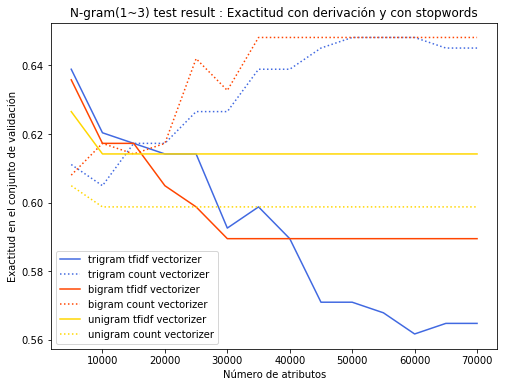

In [182]:
# Adaptado de https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-5-50b4e87d9bdd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time
from sklearn import metrics

X_tot_raw = conjunto_final.Texto_limpio_stem
X_train_val_raw = X_tot_raw[:dfsTASS.shape[0]]
Y_train_val_raw = Y_train_val
X_test_raw = X_tot_raw[dfsTASS.shape[0]:]
X_train_raw, X_val_raw, Y_train_raw, Y_val_raw = train_test_split(X_train_val_raw, Y_train_val_raw, test_size=0.1, random_state=0)

x_train, x_validation, x_test, y_train, y_validation, y_test = X_train_raw, X_val_raw, X_test_raw, Y_train_raw, Y_val_raw, Y_test


def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_train)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.4f}".format(null_accuracy*100))
    print ("accuracy score: {0:.4f}".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.4f} more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.4f} less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("train and test time: {0:.4f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time

cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(5000,70001,5000)
#n_features = np.arange(10000,100001,10000)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print ("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

feature_result_ugt = nfeature_accuracy_checker(vectorizer=tvec)
feature_result_bgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 2))
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 3))

feature_result_ugc = nfeature_accuracy_checker(vectorizer=cvec)
feature_result_bgc = nfeature_accuracy_checker(vectorizer=cvec,ngram_range=(1, 2))
feature_result_tgc = nfeature_accuracy_checker(vectorizer=cvec,ngram_range=(1, 3))

nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bgt = pd.DataFrame(feature_result_bgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt,columns=['nfeatures','validation_accuracy','train_test_time'])

nfeatures_plot_tgc = pd.DataFrame(feature_result_tgc,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bgc = pd.DataFrame(feature_result_bgc,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugc = pd.DataFrame(feature_result_ugc,columns=['nfeatures','validation_accuracy','train_test_time'])


plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(nfeatures_plot_tgc.nfeatures, nfeatures_plot_tgc.validation_accuracy,label='trigram count vectorizer',linestyle=':', color='royalblue')
plt.plot(nfeatures_plot_bgt.nfeatures, nfeatures_plot_bgt.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
plt.plot(nfeatures_plot_bgc.nfeatures, nfeatures_plot_bgc.validation_accuracy,label='bigram count vectorizer',linestyle=':',color='orangered')
plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
plt.plot(nfeatures_plot_ugc.nfeatures, nfeatures_plot_ugc.validation_accuracy, label='unigram count vectorizer',linestyle=':',color='gold')
plt.title("N-gram(1~3) test result : Exactitud con derivación y con stopwords")
plt.xlabel("Número de atributos")
plt.ylabel("Exactitud en el conjunto de validación")
plt.legend()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 5000 features
null accuracy: 75.8157
accuracy score: 42.1305
model is 33.6852 less accurate than null accuracy
train and test time: 0.1387s
--------------------------------------------------------------------------------
Validation result for 10000 features
null accuracy: 75.8157
accuracy score: 41.2668
model is 34.5489 less accurate than null accuracy
train and test time: 0.1316s
--------------------------------------------------------------------------------
Validation result for 15000 features
null accuracy: 75.8157
accuracy score: 41.2668
model is 34.5489 less accurate than null accuracy
train and test time: 0.1446s
--------------------------------------------------------------------------------
Va

null accuracy: 75.8157
accuracy score: 39.2514
model is 36.5643 less accurate than null accuracy
train and test time: 0.5221s
--------------------------------------------------------------------------------
Validation result for 25000 features
null accuracy: 75.8157
accuracy score: 38.0998
model is 37.7159 less accurate than null accuracy
train and test time: 0.4528s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 75.8157
accuracy score: 37.7159
model is 38.0998 less accurate than null accuracy
train and test time: 0.5232s
--------------------------------------------------------------------------------
Validation result for 35000 features
null accuracy: 75.8157
accuracy score: 36.4683
model is 39.3474 less accurate than null accuracy
train and test time: 0.4428s
--------------------------------------------------------------------------------
Validation result for 40000 features
null accuracy: 75.8157
a

null accuracy: 75.8157
accuracy score: 48.0806
model is 27.7351 less accurate than null accuracy
train and test time: 0.4972s
--------------------------------------------------------------------------------
Validation result for 45000 features
null accuracy: 75.8157
accuracy score: 48.0806
model is 27.7351 less accurate than null accuracy
train and test time: 0.4936s
--------------------------------------------------------------------------------
Validation result for 50000 features
null accuracy: 75.8157
accuracy score: 48.0806
model is 27.7351 less accurate than null accuracy
train and test time: 0.3730s
--------------------------------------------------------------------------------
Validation result for 55000 features
null accuracy: 75.8157
accuracy score: 48.0806
model is 27.7351 less accurate than null accuracy
train and test time: 0.3830s
--------------------------------------------------------------------------------
Validation result for 60000 features
null accuracy: 75.8157
a

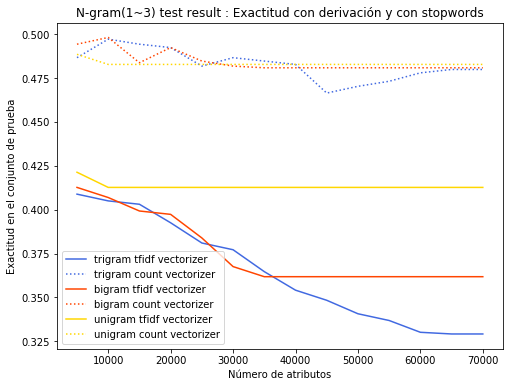

In [183]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_train)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.4f}".format(null_accuracy*100))
    print ("accuracy score: {0:.4f}".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.4f} more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.4f} less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("train and test time: {0:.4f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time

cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(5000,70001,5000)
#n_features = np.arange(10000,100001,10000)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print ("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_test, y_test)
        result.append((n,nfeature_accuracy,tt_time))
    return result

from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

feature_result_ugt = nfeature_accuracy_checker(vectorizer=tvec)
feature_result_bgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 2))
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 3))

feature_result_ugc = nfeature_accuracy_checker(vectorizer=cvec)
feature_result_bgc = nfeature_accuracy_checker(vectorizer=cvec,ngram_range=(1, 2))
feature_result_tgc = nfeature_accuracy_checker(vectorizer=cvec,ngram_range=(1, 3))

nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bgt = pd.DataFrame(feature_result_bgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt,columns=['nfeatures','validation_accuracy','train_test_time'])

nfeatures_plot_tgc = pd.DataFrame(feature_result_tgc,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bgc = pd.DataFrame(feature_result_bgc,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugc = pd.DataFrame(feature_result_ugc,columns=['nfeatures','validation_accuracy','train_test_time'])


plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(nfeatures_plot_tgc.nfeatures, nfeatures_plot_tgc.validation_accuracy,label='trigram count vectorizer',linestyle=':', color='royalblue')
plt.plot(nfeatures_plot_bgt.nfeatures, nfeatures_plot_bgt.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
plt.plot(nfeatures_plot_bgc.nfeatures, nfeatures_plot_bgc.validation_accuracy,label='bigram count vectorizer',linestyle=':',color='orangered')
plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
plt.plot(nfeatures_plot_ugc.nfeatures, nfeatures_plot_ugc.validation_accuracy, label='unigram count vectorizer',linestyle=':',color='gold')
plt.title("N-gram(1~3) test result : Exactitud con derivación y con stopwords")
plt.xlabel("Número de atributos")
plt.ylabel("Exactitud en el conjunto de prueba")
plt.legend()

### Desempeño de varios clasificadores en los datos etiquetados de Uribe y Santos ensayando Bag of Words, usando derivación y 10000 atributos 

In [195]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel

names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]
zipped_clf = zip(names,classifiers)

#tvec = TfidfVectorizer()
cvec = CountVectorizer()
def classifier_comparator(vectorizer=cvec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print ("Validation result for {}".format(n))
        print (c)
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_test, y_test)
        result.append((n,clf_accuracy,tt_time))
    return result

unigram_result = classifier_comparator(n_features=10000,ngram_range=(1,1))

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
null accuracy: 75.8157
accuracy score: 48.2726
model is 27.5432 less accurate than null accuracy
train and test time: 0.1536s
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
null accuracy: 75.8157
accuracy score: 49.0403
model is 26.7754 less accurate than null accuracy
train and test time: 0.2593s
--------------------------------------------------------------------------------
Validation result for LinearSVC

C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(sel

### Desempeño de un clasificador basado en Regresión Logística en datos del corpus del TASS y en los datos etiquetados de Uribe y Santos ensayando Bag of Words y TF-IDF variando el número de atributos y usando lematización

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 5000 features
null accuracy: 57.0988
accuracy score: 60.8025
model is 3.7037 more accurate than null accuracy
train and test time: 0.0818s
--------------------------------------------------------------------------------
Validation result for 10000 features
null accuracy: 57.0988
accuracy score: 59.5679
model is 2.4691 more accurate than null accuracy
train and test time: 0.0902s
--------------------------------------------------------------------------------
Validation result for 15000 features
null accuracy: 57.0988
accuracy score: 59.5679
model is 2.4691 more accurate than null accuracy
train and test time: 0.0977s
--------------------------------------------------------------------------------
Valid

null accuracy: 57.0988
accuracy score: 59.2593
model is 2.1605 more accurate than null accuracy
train and test time: 0.3603s
--------------------------------------------------------------------------------
Validation result for 25000 features
null accuracy: 57.0988
accuracy score: 58.6420
model is 1.5432 more accurate than null accuracy
train and test time: 0.4696s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 57.0988
accuracy score: 58.0247
model is 0.9259 more accurate than null accuracy
train and test time: 0.3590s
--------------------------------------------------------------------------------
Validation result for 35000 features
null accuracy: 57.0988
accuracy score: 58.6420
model is 1.5432 more accurate than null accuracy
train and test time: 0.4089s
--------------------------------------------------------------------------------
Validation result for 40000 features
null accuracy: 57.0988
accur

null accuracy: 57.0988
accuracy score: 64.8148
model is 7.7160 more accurate than null accuracy
train and test time: 0.4194s
--------------------------------------------------------------------------------
Validation result for 45000 features
null accuracy: 57.0988
accuracy score: 64.8148
model is 7.7160 more accurate than null accuracy
train and test time: 0.3195s
--------------------------------------------------------------------------------
Validation result for 50000 features
null accuracy: 57.0988
accuracy score: 64.8148
model is 7.7160 more accurate than null accuracy
train and test time: 0.4299s
--------------------------------------------------------------------------------
Validation result for 55000 features
null accuracy: 57.0988
accuracy score: 64.8148
model is 7.7160 more accurate than null accuracy
train and test time: 0.3317s
--------------------------------------------------------------------------------
Validation result for 60000 features
null accuracy: 57.0988
accur

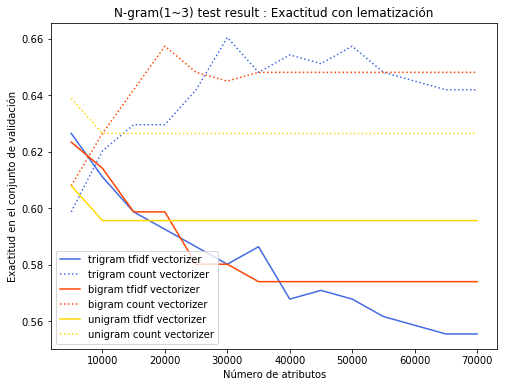

In [184]:
# Adaptado de https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-5-50b4e87d9bdd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time
from sklearn import metrics

X_tot_raw = conjunto_final.Texto_limpio_lemas
X_train_val_raw = X_tot_raw[:dfsTASS.shape[0]]
Y_train_val_raw = Y_train_val
X_test_raw = X_tot_raw[dfsTASS.shape[0]:]
X_train_raw, X_val_raw, Y_train_raw, Y_val_raw = train_test_split(X_train_val_raw, Y_train_val_raw, test_size=0.1, random_state=0)

x_train, x_validation, x_test, y_train, y_validation, y_test = X_train_raw, X_val_raw, X_test_raw, Y_train_raw, Y_val_raw, Y_test


def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_train)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.4f}".format(null_accuracy*100))
    print ("accuracy score: {0:.4f}".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.4f} more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.4f} less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("train and test time: {0:.4f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time

cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(5000,70001,5000)
#n_features = np.arange(10000,100001,10000)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print ("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

feature_result_ugt = nfeature_accuracy_checker(vectorizer=tvec)
feature_result_bgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 2))
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 3))

feature_result_ugc = nfeature_accuracy_checker(vectorizer=cvec)
feature_result_bgc = nfeature_accuracy_checker(vectorizer=cvec,ngram_range=(1, 2))
feature_result_tgc = nfeature_accuracy_checker(vectorizer=cvec,ngram_range=(1, 3))

nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bgt = pd.DataFrame(feature_result_bgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt,columns=['nfeatures','validation_accuracy','train_test_time'])

nfeatures_plot_tgc = pd.DataFrame(feature_result_tgc,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bgc = pd.DataFrame(feature_result_bgc,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugc = pd.DataFrame(feature_result_ugc,columns=['nfeatures','validation_accuracy','train_test_time'])


plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(nfeatures_plot_tgc.nfeatures, nfeatures_plot_tgc.validation_accuracy,label='trigram count vectorizer',linestyle=':', color='royalblue')
plt.plot(nfeatures_plot_bgt.nfeatures, nfeatures_plot_bgt.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
plt.plot(nfeatures_plot_bgc.nfeatures, nfeatures_plot_bgc.validation_accuracy,label='bigram count vectorizer',linestyle=':',color='orangered')
plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
plt.plot(nfeatures_plot_ugc.nfeatures, nfeatures_plot_ugc.validation_accuracy, label='unigram count vectorizer',linestyle=':',color='gold')
plt.title("N-gram(1~3) test result : Exactitud con lematización")
plt.xlabel("Número de atributos")
plt.ylabel("Exactitud en el conjunto de validación")
plt.legend()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 5000 features
null accuracy: 75.8157
accuracy score: 40.4031
model is 35.4127 less accurate than null accuracy
train and test time: 0.1247s
--------------------------------------------------------------------------------
Validation result for 10000 features
null accuracy: 75.8157
accuracy score: 40.0192
model is 35.7965 less accurate than null accuracy
train and test time: 0.1086s
--------------------------------------------------------------------------------
Validation result for 15000 features
null accuracy: 75.8157
accuracy score: 40.0192
model is 35.7965 less accurate than null accuracy
train and test time: 0.1067s
--------------------------------------------------------------------------------
Va

null accuracy: 75.8157
accuracy score: 37.0441
model is 38.7716 less accurate than null accuracy
train and test time: 0.3780s
--------------------------------------------------------------------------------
Validation result for 25000 features
null accuracy: 75.8157
accuracy score: 36.1804
model is 39.6353 less accurate than null accuracy
train and test time: 0.3610s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 75.8157
accuracy score: 35.5086
model is 40.3071 less accurate than null accuracy
train and test time: 0.4025s
--------------------------------------------------------------------------------
Validation result for 35000 features
null accuracy: 75.8157
accuracy score: 34.7409
model is 41.0749 less accurate than null accuracy
train and test time: 0.5131s
--------------------------------------------------------------------------------
Validation result for 40000 features
null accuracy: 75.8157
a

null accuracy: 75.8157
accuracy score: 44.3378
model is 31.4779 less accurate than null accuracy
train and test time: 0.3286s
--------------------------------------------------------------------------------
Validation result for 45000 features
null accuracy: 75.8157
accuracy score: 44.3378
model is 31.4779 less accurate than null accuracy
train and test time: 0.3560s
--------------------------------------------------------------------------------
Validation result for 50000 features
null accuracy: 75.8157
accuracy score: 44.3378
model is 31.4779 less accurate than null accuracy
train and test time: 0.4548s
--------------------------------------------------------------------------------
Validation result for 55000 features
null accuracy: 75.8157
accuracy score: 44.3378
model is 31.4779 less accurate than null accuracy
train and test time: 0.4189s
--------------------------------------------------------------------------------
Validation result for 60000 features
null accuracy: 75.8157
a

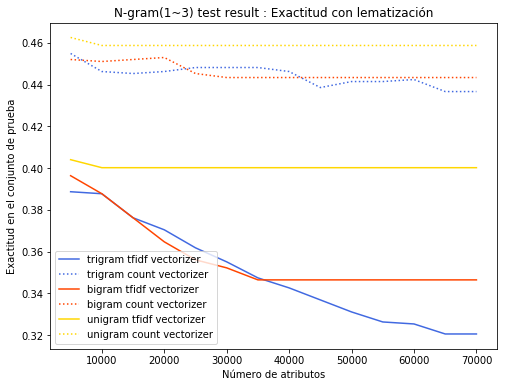

In [188]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_train)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.4f}".format(null_accuracy*100))
    print ("accuracy score: {0:.4f}".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.4f} more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.4f} less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("train and test time: {0:.4f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time

cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(5000,70001,5000)
#n_features = np.arange(10000,100001,10000)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print ("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_test, y_test)
        result.append((n,nfeature_accuracy,tt_time))
    return result

from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

feature_result_ugt = nfeature_accuracy_checker(vectorizer=tvec)
feature_result_bgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 2))
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 3))

feature_result_ugc = nfeature_accuracy_checker(vectorizer=cvec)
feature_result_bgc = nfeature_accuracy_checker(vectorizer=cvec,ngram_range=(1, 2))
feature_result_tgc = nfeature_accuracy_checker(vectorizer=cvec,ngram_range=(1, 3))

nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bgt = pd.DataFrame(feature_result_bgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt,columns=['nfeatures','validation_accuracy','train_test_time'])

nfeatures_plot_tgc = pd.DataFrame(feature_result_tgc,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bgc = pd.DataFrame(feature_result_bgc,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugc = pd.DataFrame(feature_result_ugc,columns=['nfeatures','validation_accuracy','train_test_time'])


plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(nfeatures_plot_tgc.nfeatures, nfeatures_plot_tgc.validation_accuracy,label='trigram count vectorizer',linestyle=':', color='royalblue')
plt.plot(nfeatures_plot_bgt.nfeatures, nfeatures_plot_bgt.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
plt.plot(nfeatures_plot_bgc.nfeatures, nfeatures_plot_bgc.validation_accuracy,label='bigram count vectorizer',linestyle=':',color='orangered')
plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
plt.plot(nfeatures_plot_ugc.nfeatures, nfeatures_plot_ugc.validation_accuracy, label='unigram count vectorizer',linestyle=':',color='gold')
plt.title("N-gram(1~3) test result : Exactitud con lematización")
plt.xlabel("Número de atributos")
plt.ylabel("Exactitud en el conjunto de prueba")
plt.legend()

### Desempeño de varios clasificadores en los datos etiquetados de Uribe y Santos ensayando Bag of Words, usando lematización, unigramas y 10000 atributos 

In [190]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel

names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]
zipped_clf = zip(names,classifiers)

#tvec = TfidfVectorizer()
cvec = CountVectorizer()
def classifier_comparator(vectorizer=cvec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print ("Validation result for {}".format(n))
        print (c)
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_test, y_test)
        result.append((n,clf_accuracy,tt_time))
    return result

unigram_result = classifier_comparator(n_features=10000,ngram_range=(1,1))

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
null accuracy: 75.8157
accuracy score: 45.8733
model is 29.9424 less accurate than null accuracy
train and test time: 0.1312s
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
null accuracy: 75.8157
accuracy score: 45.5854
model is 30.2303 less accurate than null accuracy
train and test time: 0.2154s
--------------------------------------------------------------------------------
Validation result for LinearSVC

C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(sel

null accuracy: 75.8157
accuracy score: 45.2975
model is 30.5182 less accurate than null accuracy
train and test time: 0.0977s
--------------------------------------------------------------------------------


### Desempeño de un clasificador basado en Regresión Logística en datos del corpus del TASS y en los datos etiquetados de Uribe y Santos ensayando Bag of Words y TF-IDF, variando el número de atributos, usando derivación y eliminando stopwords

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 5000 features
null accuracy: 57.0988
accuracy score: 59.5679
model is 2.4691 more accurate than null accuracy
train and test time: 0.1017s
--------------------------------------------------------------------------------
Validation result for 10000 features
null accuracy: 57.0988
accuracy score: 58.9506
model is 1.8519 more accurate than null accuracy
train and test time: 0.0908s
--------------------------------------------------------------------------------
Validation result for 15000 features
null accuracy: 57.0988
accuracy score: 58.9506
model is 1.8519 more accurate than null accuracy
train and test time: 0.1087s
--------------------------------------------------------------------------------
Valid

null accuracy: 57.0988
accuracy score: 59.2593
model is 2.1605 more accurate than null accuracy
train and test time: 0.4194s
--------------------------------------------------------------------------------
Validation result for 25000 features
null accuracy: 57.0988
accuracy score: 58.6420
model is 1.5432 more accurate than null accuracy
train and test time: 0.3361s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 57.0988
accuracy score: 58.0247
model is 0.9259 more accurate than null accuracy
train and test time: 0.3149s
--------------------------------------------------------------------------------
Validation result for 35000 features
null accuracy: 57.0988
accuracy score: 57.0988
model has the same accuracy with the null accuracy
train and test time: 0.3211s
--------------------------------------------------------------------------------
Validation result for 40000 features
null accuracy: 57.0988
acc

null accuracy: 57.0988
accuracy score: 61.7284
model is 4.6296 more accurate than null accuracy
train and test time: 0.2733s
--------------------------------------------------------------------------------
Validation result for 45000 features
null accuracy: 57.0988
accuracy score: 61.7284
model is 4.6296 more accurate than null accuracy
train and test time: 0.2563s
--------------------------------------------------------------------------------
Validation result for 50000 features
null accuracy: 57.0988
accuracy score: 61.7284
model is 4.6296 more accurate than null accuracy
train and test time: 0.2498s
--------------------------------------------------------------------------------
Validation result for 55000 features
null accuracy: 57.0988
accuracy score: 61.7284
model is 4.6296 more accurate than null accuracy
train and test time: 0.2473s
--------------------------------------------------------------------------------
Validation result for 60000 features
null accuracy: 57.0988
accur

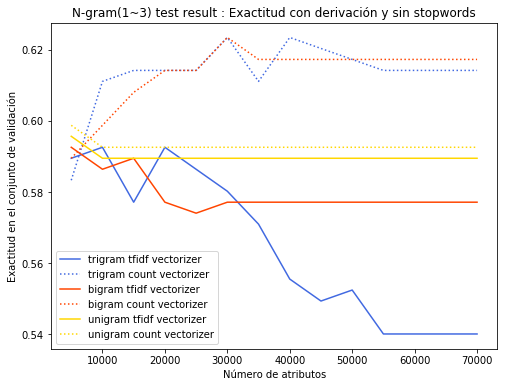

In [192]:
# Adaptado de https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-5-50b4e87d9bdd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time
from sklearn import metrics

X_tot_raw = conjunto_final.Texto_limpio_stem
X_train_val_raw = X_tot_raw[:dfsTASS.shape[0]]
Y_train_val_raw = Y_train_val
X_test_raw = X_tot_raw[dfsTASS.shape[0]:]
X_train_raw, X_val_raw, Y_train_raw, Y_val_raw = train_test_split(X_train_val_raw, Y_train_val_raw, test_size=0.1, random_state=0)

x_train, x_validation, x_test, y_train, y_validation, y_test = X_train_raw, X_val_raw, X_test_raw, Y_train_raw, Y_val_raw, Y_test


def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_train)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.4f}".format(null_accuracy*100))
    print ("accuracy score: {0:.4f}".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.4f} more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.4f} less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("train and test time: {0:.4f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time

cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(5000,70001,5000)
#n_features = np.arange(10000,100001,10000)
stop = stopwords.words('spanish')

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=stop, ngram_range=(1, 1), classifier=lr):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print ("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

feature_result_ugt = nfeature_accuracy_checker(vectorizer=tvec)
feature_result_bgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 2))
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 3))

feature_result_ugc = nfeature_accuracy_checker(vectorizer=cvec)
feature_result_bgc = nfeature_accuracy_checker(vectorizer=cvec,ngram_range=(1, 2))
feature_result_tgc = nfeature_accuracy_checker(vectorizer=cvec,ngram_range=(1, 3))

nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bgt = pd.DataFrame(feature_result_bgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt,columns=['nfeatures','validation_accuracy','train_test_time'])

nfeatures_plot_tgc = pd.DataFrame(feature_result_tgc,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bgc = pd.DataFrame(feature_result_bgc,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugc = pd.DataFrame(feature_result_ugc,columns=['nfeatures','validation_accuracy','train_test_time'])


plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(nfeatures_plot_tgc.nfeatures, nfeatures_plot_tgc.validation_accuracy,label='trigram count vectorizer',linestyle=':', color='royalblue')
plt.plot(nfeatures_plot_bgt.nfeatures, nfeatures_plot_bgt.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
plt.plot(nfeatures_plot_bgc.nfeatures, nfeatures_plot_bgc.validation_accuracy,label='bigram count vectorizer',linestyle=':',color='orangered')
plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
plt.plot(nfeatures_plot_ugc.nfeatures, nfeatures_plot_ugc.validation_accuracy, label='unigram count vectorizer',linestyle=':',color='gold')
plt.title("N-gram(1~3) test result : Exactitud con derivación y sin stopwords")
plt.xlabel("Número de atributos")
plt.ylabel("Exactitud en el conjunto de validación")
plt.legend()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 5000 features
null accuracy: 75.8157
accuracy score: 40.6910
model is 35.1248 less accurate than null accuracy
train and test time: 0.1038s
--------------------------------------------------------------------------------
Validation result for 10000 features
null accuracy: 75.8157
accuracy score: 40.3071
model is 35.5086 less accurate than null accuracy
train and test time: 0.1157s
--------------------------------------------------------------------------------
Validation result for 15000 features
null accuracy: 75.8157
accuracy score: 40.3071
model is 35.5086 less accurate than null accuracy
train and test time: 0.1067s
--------------------------------------------------------------------------------
Va

null accuracy: 75.8157
accuracy score: 37.3321
model is 38.4837 less accurate than null accuracy
train and test time: 0.4224s
--------------------------------------------------------------------------------
Validation result for 25000 features
null accuracy: 75.8157
accuracy score: 36.2764
model is 39.5393 less accurate than null accuracy
train and test time: 0.3969s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 75.8157
accuracy score: 35.7006
model is 40.1152 less accurate than null accuracy
train and test time: 0.4628s
--------------------------------------------------------------------------------
Validation result for 35000 features
null accuracy: 75.8157
accuracy score: 35.7006
model is 40.1152 less accurate than null accuracy
train and test time: 0.4249s
--------------------------------------------------------------------------------
Validation result for 40000 features
null accuracy: 75.8157
a

null accuracy: 75.8157
accuracy score: 44.2418
model is 31.5739 less accurate than null accuracy
train and test time: 0.4583s
--------------------------------------------------------------------------------
Validation result for 45000 features
null accuracy: 75.8157
accuracy score: 44.2418
model is 31.5739 less accurate than null accuracy
train and test time: 0.4000s
--------------------------------------------------------------------------------
Validation result for 50000 features
null accuracy: 75.8157
accuracy score: 44.2418
model is 31.5739 less accurate than null accuracy
train and test time: 0.3999s
--------------------------------------------------------------------------------
Validation result for 55000 features
null accuracy: 75.8157
accuracy score: 44.2418
model is 31.5739 less accurate than null accuracy
train and test time: 0.4239s
--------------------------------------------------------------------------------
Validation result for 60000 features
null accuracy: 75.8157
a

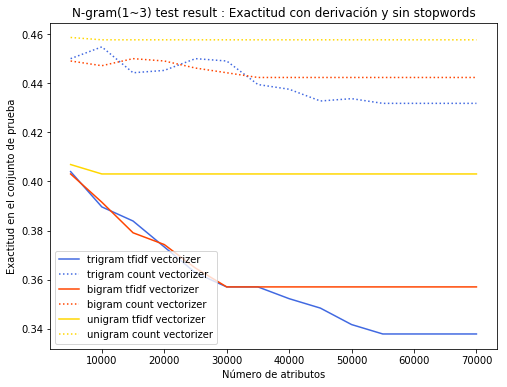

In [193]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_train)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.4f}".format(null_accuracy*100))
    print ("accuracy score: {0:.4f}".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.4f} more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.4f} less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("train and test time: {0:.4f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time

cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(5000,70001,5000)
#n_features = np.arange(10000,100001,10000)
stop = stopwords.words('spanish')

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=stop, ngram_range=(1, 1), classifier=lr):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print ("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_test, y_test)
        result.append((n,nfeature_accuracy,tt_time))
    return result

from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

feature_result_ugt = nfeature_accuracy_checker(vectorizer=tvec)
feature_result_bgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 2))
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 3))

feature_result_ugc = nfeature_accuracy_checker(vectorizer=cvec)
feature_result_bgc = nfeature_accuracy_checker(vectorizer=cvec,ngram_range=(1, 2))
feature_result_tgc = nfeature_accuracy_checker(vectorizer=cvec,ngram_range=(1, 3))

nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bgt = pd.DataFrame(feature_result_bgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt,columns=['nfeatures','validation_accuracy','train_test_time'])

nfeatures_plot_tgc = pd.DataFrame(feature_result_tgc,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bgc = pd.DataFrame(feature_result_bgc,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugc = pd.DataFrame(feature_result_ugc,columns=['nfeatures','validation_accuracy','train_test_time'])


plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(nfeatures_plot_tgc.nfeatures, nfeatures_plot_tgc.validation_accuracy,label='trigram count vectorizer',linestyle=':', color='royalblue')
plt.plot(nfeatures_plot_bgt.nfeatures, nfeatures_plot_bgt.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
plt.plot(nfeatures_plot_bgc.nfeatures, nfeatures_plot_bgc.validation_accuracy,label='bigram count vectorizer',linestyle=':',color='orangered')
plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
plt.plot(nfeatures_plot_ugc.nfeatures, nfeatures_plot_ugc.validation_accuracy, label='unigram count vectorizer',linestyle=':',color='gold')
plt.title("N-gram(1~3) test result : Exactitud con derivación y sin stopwords")
plt.xlabel("Número de atributos")
plt.ylabel("Exactitud en el conjunto de prueba")
plt.legend()

### Desempeño de varios clasificadores en los datos etiquetados de Uribe y Santos ensayando Bag of Words, variando el número de atributos, usando derivación y eliminando stopwords

In [194]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel

names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]
zipped_clf = zip(names,classifiers)

#tvec = TfidfVectorizer()
cvec = CountVectorizer()
stop = stopwords.words('spanish')

def classifier_comparator(vectorizer=cvec, n_features=10000, stop_words=stop, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print ("Validation result for {}".format(n))
        print (c)
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_test, y_test)
        result.append((n,clf_accuracy,tt_time))
    return result

unigram_result = classifier_comparator(n_features=10000,ngram_range=(1,1))

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
null accuracy: 75.8157
accuracy score: 45.7774
model is 30.0384 less accurate than null accuracy
train and test time: 0.1172s
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
null accuracy: 75.8157
accuracy score: 47.7927
model is 28.0230 less accurate than null accuracy
train and test time: 0.1770s
--------------------------------------------------------------------------------
Validation result for LinearSVC

C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(sel

#### Validación cruzada con SVM Lineal usando derivación con stopwords y matriz de confusión

Mejor valor de C : 0.1
Mayor exactitud en fase de validación : 0.46634615384615385
Exactitud en conjunto de prueba usando mejor valor de C: 0.5155875299760192


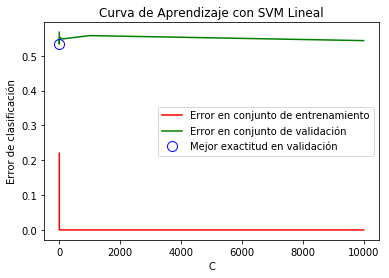

In [229]:
# Adaptado de https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-5-50b4e87d9bdd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from time import time
from sklearn import metrics

X_tot_raw = conjunto_final.Texto_limpio_stem
X_train_val_raw = X_tot_raw[:dfsTASS.shape[0]]
Y_train_val_raw = Y_train_val
X_test_raw = X_tot_raw[dfsTASS.shape[0]:]
#X_train_raw, X_val_raw, Y_train_raw, Y_val_raw = train_test_split(X_train_val_raw, Y_train_val_raw, test_size=0.1, random_state=0)
X_val_raw, X_test_raw, Y_val_raw, Y_test_raw = train_test_split(X_test_raw, Y_test, test_size=0.8, random_state=0)
#x_train, x_validation, x_test, y_train, y_validation, y_test = X_train_raw, X_val_raw, X_test_raw, Y_train_raw, Y_val_raw, Y_test
x_train, x_validation, x_test, y_train, y_validation, y_test = X_train_val_raw, X_val_raw, X_test_raw, Y_train_val_raw, Y_val_raw, Y_test_raw 

mejor_score = 0
mejor_C = None
mejor_modelo_sv = None
sv_error_train = []
sv_error_val = []

cvec = CountVectorizer()
cvec.set_params(stop_words=None, max_features=10000, ngram_range=(1, 1))
C_grid = np.logspace(-2,4,7) 

def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred_train = sentiment_fit.predict(x_train)
    y_pred_val = sentiment_fit.predict(x_test)
    accuracy_train = metrics.accuracy_score(y_train, y_pred_train)
    accuracy_val = metrics.accuracy_score(y_test, y_pred_val)
    return accuracy_train, accuracy_val, y_pred_val

for C in C_grid: 
    classifier = LinearSVC(C=C)
    checker_pipeline = Pipeline([
            ('vectorizer', cvec),
            ('classifier', classifier)
        ])
    score_train,score_val, y_pred = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
    sv_error_train.append(1 - score_train)
    sv_error_val.append(1 - score_val)
    
    if score_val > mejor_score: 
        mejor_score = score_val
        mejor_C = C
        mejor_modelo_sv = classifier


classifier = LinearSVC(C=mejor_C)
checker_pipeline = Pipeline([
    ('vectorizer', cvec),
    ('classifier', classifier)
])
score_train,score_test,y_pred = accuracy_summary(checker_pipeline, x_train, y_train, x_test, y_test)
print ("Mejor valor de C :", mejor_C)
print ("Mayor exactitud en fase de validación :", mejor_score)
print ("Exactitud en conjunto de prueba usando mejor valor de C:", score_test)

plt.figure()
plt.plot(C_grid, sv_error_train,
        label='Error en conjunto de entrenamiento',
        color='red')
plt.plot(C_grid, sv_error_val,
        label='Error en conjunto de validación',
        color='green')
plt.plot(mejor_C, 1-mejor_score, 'o', markersize=10,
         label="Mejor exactitud en validación", fillstyle="none", c='b', mew=1)
plt.xlabel("C")
plt.ylabel("Error de clasificación")
plt.title("Curva de Aprendizaje con SVM Lineal")
plt.legend(loc=0, numpoints=1)
plt.show()


In [238]:
y_true.value_counts()

2    403
1    223
0    208
Name: Actual, dtype: int64

Confusion matrix, without normalization
[[137  40  31]
 [ 70  88  65]
 [117  81 205]]
Normalized confusion matrix
[[0.65865385 0.19230769 0.14903846]
 [0.31390135 0.39461883 0.29147982]
 [0.29032258 0.20099256 0.50868486]]


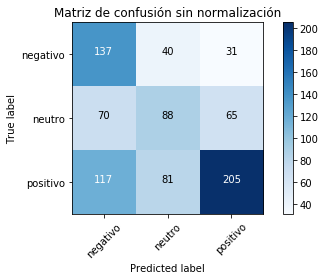

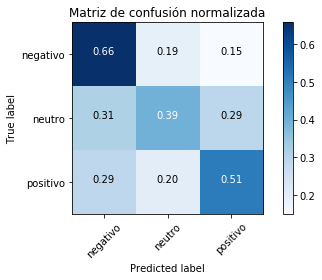

In [239]:
# Adaptado de https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
from sklearn.metrics import confusion_matrix
y_true = y_test
y_pred = y_pred
cnf_matrix = confusion_matrix(y_true, y_pred)

class_names = ['negativo','neutro','positivo']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Matriz de confusión sin normalización')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Matriz de confusión normalizada')

In [240]:
print(dataUribeSP.shape)
print(dataSantosSP.shape)

(3056, 8)
(3181, 8)


In [245]:
dtotalUyS = dataUribeSP.append(dataSantosSP, ignore_index=True)
#dtotalUyS.head()

In [243]:
dtotalUyS.shape

(6237, 8)

In [247]:
dtotalUyS['Texto_procesado_stem'] = dtotalUyS.Text.apply(processAll)
dtotalUyS['Texto_limpio_stem'] = dtotalUyS.Texto_procesado_stem.apply(unir)
dtotalUyS.head()

,ID,Date,Source,Likes,RTs,Text,Lang,long,Texto_procesado_stem,Texto_limpio_stem
0,1068264150390972421,2018-11-29 22:03:15,Twitter for iPhone,0,17,RT @JenniferAriasF: El empoderamiento de las m...,es,140,"[__user_JENNIFERARIASF, empoder, las, mujer, c...",__user_JENNIFERARIASF empoder las mujer camin ...
1,1068254080055894019,2018-11-29 21:23:14,Twitter for iPhone,0,20,RT @gabrieljvelasco: #FelizJueves | Buena inic...,es,140,"[__user_GABRIELJVELASCO, __HASH_FELIZJUEVES, b...",__user_GABRIELJVELASCO __HASH_FELIZJUEVES buen...
2,1068199640833695744,2018-11-29 17:46:55,Twitter for iPhone,1721,752,Por segunda vez recuerdo que los congresistas ...,es,114,"[por, segund, vez, recuerd, que, los, congres,...",por segund vez recuerd que los congres del cen...
3,1068188384064126976,2018-11-29 17:02:11,Twitter for iPhone,0,17,RT @polojuancho16: Felicitaciones a la Conceja...,es,140,"[__user_POLOJUANCHO16, felicit, concejal, del,...",__user_POLOJUANCHO16 felicit concejal del __us...
4,1068152587793440769,2018-11-29 14:39:56,Twitter for iPhone,0,114,RT @FelipeSogamoso: Fueron cientos los caídos ...,es,140,"[__user_FELIPESOGAMOSO, fueron, cient, los, ca...",__user_FELIPESOGAMOSO fueron cient los caid ac...


In [248]:
#Y_train_val = targets[:dfsTASS.shape[0]]
#Y_test = targets[dfsTASS.shape[0]:]

X_tot_raw = conjunto_final.Texto_limpio_stem
X_train = X_tot_raw[:dfsTASS.shape[0]]
Y_train = targets[:dfsTASS.shape[0]]
X_test = dtotalUyS.Texto_limpio_stem

x_train, x_test, y_train = X_train, X_test, Y_train

cvec = CountVectorizer()
cvec.set_params(stop_words=None, max_features=10000, ngram_range=(1, 1))

def predicciones(pipeline, x_train, y_train, x_test):
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred_test = sentiment_fit.predict(x_test)
    return y_pred_test

classifier = LinearSVC(C=0.1)
checker_pipeline = Pipeline([
    ('vectorizer', cvec),
    ('classifier', classifier)
])

y_pred = predicciones(checker_pipeline, x_train, y_train, x_test)

In [252]:
dtotalUyS['polaridad_predicha'] = y_pred

In [261]:
results = dtotalUyS.polaridad_predicha.value_counts()

In [272]:
results[0:]

0    2540
2    2140
1    1557
Name: polaridad_predicha, dtype: int64

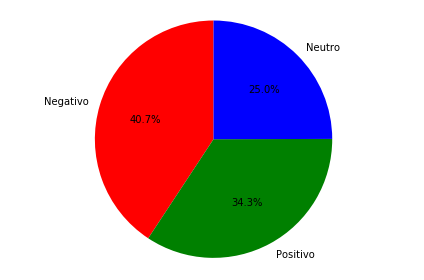

In [280]:
datos = dtotalUyS['polaridad_predicha'].value_counts()
polaridades = ['Negativo', 'Positivo', 'Neutro']
colors = ['r', 'g', 'b']
plt.pie(datos, labels=polaridades, colors=colors, startangle=90, autopct='%.1f%%')
plt.axis('equal')
plt.tight_layout()
plt.show()